In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperatures
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperatures
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperatures
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    agg.columns = names

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(84):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(84):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)

    diff_values = []
    
    for ws in range(21):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    # Transform each weather station as a separate "batch"
    for ws in range(21):
        # transform into supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 11:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 46:
    n_lag = 179 - n_seq + 46
else:
    n_lag = 179
n_time_steps = 227
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([1, 2, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 
                        23, 24, 25, 27, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 
                        43, 44, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 
                        62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 
                        82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103])
test_array.append([0, 4, 10, 12, 18, 26, 30, 31, 33, 45, 47, 53, 64, 65, 77, 80, 89, 94, 96, 99, 104])
    
train_array.append([0, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 17, 18, 19, 20, 21, 23, 
                        24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 41, 43, 45, 
                        46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 63, 64, 
                        65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 77, 80, 81, 82, 83, 84, 
                        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104])
test_array.append([5, 9, 11, 15, 16, 22, 28, 35, 39, 40, 42, 44, 55, 56, 62, 72, 76, 78, 79, 85, 103])
    
train_array.append([0, 1, 2, 4, 5, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 26, 
                    28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 44, 45, 46, 47, 
                    48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
                    70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 89, 
                    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104])
test_array.append([3, 6, 7, 8, 13, 17, 19, 24, 25, 27, 34, 38, 43, 49, 66, 67, 68, 69, 73, 81, 84])
    
train_array.append([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 
                        35, 37, 38, 39, 40, 42, 43, 44, 45, 47, 49, 51, 52, 53, 55, 56, 
                        60, 62, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 
                        80, 81, 82, 84, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 99, 102, 103, 104])
test_array.append([32, 36, 41, 46, 48, 50, 54, 57, 58, 59, 61, 63, 70, 75, 83, 90, 91, 97, 98, 100, 101])
    
train_array.append([0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22,
                        24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 
                        42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 59, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 
                        79, 80, 81, 83, 84, 85, 89, 90, 91, 94, 96, 97, 98, 99, 100, 101, 103, 104])
test_array.append([1, 2, 14, 20, 21, 23, 29, 37, 51, 52, 60, 71, 74, 82, 86, 87, 88, 92, 93, 95, 102])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Monthly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['Day', 'vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'Month', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)
    
#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    for k in range(84):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(84):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(21):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df) 

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(21):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(84):
        train2.append(train1[k][0])
        
    for k in range(11):
        test2.append(test1[k][0])

    for k in range(10):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(84, dim_size)
    test1 = np.array(test[i]).reshape(11, dim_size)
    validation1 = np.array(validation[i]).reshape(10, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
print("Finished")

Model Parameters:
n_lag (number of input time steps): 179
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
             date  file_id  temperatures          slp  vapor_pressure  \
0      2006-01-31     6501     12.209677  1018.534543        8.674922   
1      2006-02-28     6501      8.174541  1021.230347        6.942276   
2      2006-03-31     6501     15.676613  1018.968548       10.468176   
3      2006-04-30     6501     22.464167  1014.686944       16.358802   
4      2006-05-31     6501     23.657258  1014.236828       18.798749   
...           ...      ...           ...          ...             ...   
24057  2024-07-31     9858     28.604704  1013.969355       23.769169   
24058  2024-08-31     9858     29.114919  1015.112097       23.699154   
24059  2024-09-30     9858     24.570278  1014.393750       16.790240   
24060  2024-10-31     9858     21.159140  1018.230376       10.994776   
24061  2024-11-30     9858     12.112917  10

C:\Users\User\AppData\Local\Temp\ipykernel_12652\955591540.py:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 1:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.39307412 0.69695044 0.32924264 ... 0.33095551 0.77165354 0.45747266]
 [0.45747266 0.51683609 0.42215989 ... 0.33095551 0.77165354 0.5246051 ]
 [0.38487242 0.62674714 0.3411641  ... 0.33095551 0.77165354 0.4954435 ]
 ...
 [0.54100851 0.46473952 0.46949509 ... 0.33095551 0.77165354 0.4936209 ]
 [0.44896719 0.51620076 0.3997195  ... 0.33095551 0.77165354 0.54009721]
 [0.46780073 0.52414231 0.42356241 ... 0.33095551 0.77165354 0.49696233]]
Fold 2:
(84, 1, 1, 1970)
(11, 1, 1, 1970)
(10, 1, 1, 1970)
(84, 1, 1970)
(11, 1, 1970)
(10, 1, 1970)
(84, 1970)
(11, 1970)
(10, 1970)
[[0.38166311 0.62313675 0.34639831 ... 0.33095551 0.77165354 0.47852574]
 [0.39415169 0.71548931 0.32450565 ... 0.33095551 0.77165354 0.45872677]
 [0.45872677 0.53175632 0.4180791  ... 0.33095551 0.77165354 0.52604325]
 ...
 [0.54249162 0.47861309 0.465

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
179
(84, 1970)
(11, 1970)


[I 2025-05-20 16:03:45,088] A new study created in memory with name: no-name-d1491732-2efd-48e2-91d1-0c172a10fa36
[I 2025-05-20 16:10:38,022] Trial 0 finished with value: 1.086185586452484 and parameters: {'lr': 0.12277844232142547, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2816074708643016}. Best is trial 0 with value: 1.086185586452484.


Cross Validation Accuracies:
[3.768602132797241, 0.40981557965278625, 0.3600592017173767, 0.38318607211112976, 0.5092649459838867]
Mean Cross Validation Accuracy:
1.086185586452484
Standard Deviation of Cross Validation Accuracy:
1.342172878832955


[I 2025-05-20 16:16:24,796] Trial 1 finished with value: 2.5959972858428957 and parameters: {'lr': 0.029002717772107122, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.29720442269439695}. Best is trial 0 with value: 1.086185586452484.


Cross Validation Accuracies:
[2.0210628509521484, 2.7091023921966553, 2.726466417312622, 2.727743625640869, 2.7956111431121826]
Mean Cross Validation Accuracy:
2.5959972858428957
Standard Deviation of Cross Validation Accuracy:
0.28898697335242957


[I 2025-05-20 16:24:17,703] Trial 2 finished with value: 0.13547751307487488 and parameters: {'lr': 0.006544155762606579, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.49938263643862935}. Best is trial 2 with value: 0.13547751307487488.


Cross Validation Accuracies:
[0.12507671117782593, 0.11023218929767609, 0.15920160710811615, 0.14278806746006012, 0.1400889903306961]
Mean Cross Validation Accuracy:
0.13547751307487488
Standard Deviation of Cross Validation Accuracy:
0.016631570090133028


[I 2025-05-20 16:33:04,122] Trial 3 finished with value: 0.030124995857477188 and parameters: {'lr': 0.0022122062334778455, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31712350128450784}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.02558085322380066, 0.02460821345448494, 0.032034989446401596, 0.04159444198012352, 0.026806481182575226]
Mean Cross Validation Accuracy:
0.030124995857477188
Standard Deviation of Cross Validation Accuracy:
0.006281606958011948


[I 2025-05-20 16:38:41,226] Trial 4 finished with value: 0.23411650061607361 and parameters: {'lr': 0.03602321791950463, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.21692577337291372}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.20959152281284332, 0.25236958265304565, 0.24162565171718597, 0.23419655859470367, 0.23279918730258942]
Mean Cross Validation Accuracy:
0.23411650061607361
Standard Deviation of Cross Validation Accuracy:
0.01409098019303506


[I 2025-05-20 16:46:44,019] Trial 5 finished with value: 0.06898521706461906 and parameters: {'lr': 0.02464412506071447, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.36642225045068366}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.0438091978430748, 0.10125670582056046, 0.1001553013920784, 0.057160958647727966, 0.0425439216196537]
Mean Cross Validation Accuracy:
0.06898521706461906
Standard Deviation of Cross Validation Accuracy:
0.02640382653808614


[I 2025-05-20 16:53:58,127] Trial 6 finished with value: 0.2007371336221695 and parameters: {'lr': 0.011591294918716978, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.1394013845958716}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.21797652542591095, 0.18790139257907867, 0.19291852414608002, 0.1918044239282608, 0.21308480203151703]
Mean Cross Validation Accuracy:
0.2007371336221695
Standard Deviation of Cross Validation Accuracy:
0.012290986532013123


[I 2025-05-20 16:58:22,630] Trial 7 finished with value: 0.039686468988657 and parameters: {'lr': 0.010202217894532087, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2896308153148802}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.04013126343488693, 0.031676918268203735, 0.038694243878126144, 0.04819951951503754, 0.03973039984703064]
Mean Cross Validation Accuracy:
0.039686468988657
Standard Deviation of Cross Validation Accuracy:
0.005249937422444267


[I 2025-05-20 17:02:19,641] Trial 8 finished with value: 0.0517500676214695 and parameters: {'lr': 0.03382055751891801, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.19535701856789334}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.038413096219301224, 0.047258030623197556, 0.030952412635087967, 0.05898024141788483, 0.08314655721187592]
Mean Cross Validation Accuracy:
0.0517500676214695
Standard Deviation of Cross Validation Accuracy:
0.018268062991108436


[I 2025-05-20 17:06:32,718] Trial 9 finished with value: 0.19398487806320192 and parameters: {'lr': 0.3380334416108624, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.10230462745930438}. Best is trial 3 with value: 0.030124995857477188.


Cross Validation Accuracies:
[0.1946919560432434, 0.20141826570034027, 0.1982458233833313, 0.19633005559444427, 0.17923828959465027]
Mean Cross Validation Accuracy:
0.19398487806320192
Standard Deviation of Cross Validation Accuracy:
0.0077054862944374615


[I 2025-05-20 17:11:05,756] Trial 10 finished with value: 0.024232279136776926 and parameters: {'lr': 0.001147793212458916, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3981267570131198}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.020382525399327278, 0.02744992822408676, 0.023174719884991646, 0.03206082060933113, 0.018093401566147804]
Mean Cross Validation Accuracy:
0.024232279136776926
Standard Deviation of Cross Validation Accuracy:
0.0050052808207688895


[I 2025-05-20 17:18:00,955] Trial 11 finished with value: 0.024848227202892304 and parameters: {'lr': 0.0010683172395248375, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4023456198202851}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02463420480489731, 0.0183103084564209, 0.024714428931474686, 0.02880406193435192, 0.027778131887316704]
Mean Cross Validation Accuracy:
0.024848227202892304
Standard Deviation of Cross Validation Accuracy:
0.0036617225176731874


[I 2025-05-20 17:22:18,005] Trial 12 finished with value: 0.030090908333659173 and parameters: {'lr': 0.0011080479192675848, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4416876304777838}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.0278395414352417, 0.019059546291828156, 0.03749654442071915, 0.041415102779865265, 0.024643806740641594]
Mean Cross Validation Accuracy:
0.030090908333659173
Standard Deviation of Cross Validation Accuracy:
0.008240283282549752


[I 2025-05-20 17:26:39,133] Trial 13 finished with value: 0.030923542007803916 and parameters: {'lr': 0.002476525571614257, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4109611945975472}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02562655694782734, 0.031107913702726364, 0.03529936075210571, 0.04073087498545647, 0.021853003650903702]
Mean Cross Validation Accuracy:
0.030923542007803916
Standard Deviation of Cross Validation Accuracy:
0.006718605205681248


[I 2025-05-20 17:31:04,470] Trial 14 finished with value: 0.026558416336774825 and parameters: {'lr': 0.0010343171868290699, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3850330991619689}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02693933993577957, 0.021717673167586327, 0.03253870829939842, 0.024549026042222977, 0.027047334238886833]
Mean Cross Validation Accuracy:
0.026558416336774825
Standard Deviation of Cross Validation Accuracy:
0.0035670289947627005


[I 2025-05-20 17:35:44,097] Trial 15 finished with value: 0.030620478838682175 and parameters: {'lr': 0.0038057017022016092, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4688951580214654}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.027898801490664482, 0.02389039844274521, 0.032283637672662735, 0.04215674474835396, 0.02687281183898449]
Mean Cross Validation Accuracy:
0.030620478838682175
Standard Deviation of Cross Validation Accuracy:
0.006365501490201909


[I 2025-05-20 17:42:42,265] Trial 16 finished with value: 0.27526726126670836 and parameters: {'lr': 0.004196412722925542, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.349341770565886}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.2810514271259308, 0.287386953830719, 0.28823745250701904, 0.2617950141429901, 0.25786545872688293]
Mean Cross Validation Accuracy:
0.27526726126670836
Standard Deviation of Cross Validation Accuracy:
0.01290653754917228


[I 2025-05-20 17:48:19,558] Trial 17 finished with value: 10.089405488967895 and parameters: {'lr': 0.5110615026391957, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43334188642099924}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[3.3491461277008057, 3.8461649417877197, 3.7838494777679443, 27.17621421813965, 12.29165267944336]
Mean Cross Validation Accuracy:
10.089405488967895
Standard Deviation of Cross Validation Accuracy:
9.175817245703406


[I 2025-05-20 17:52:49,451] Trial 18 finished with value: 0.031216191500425337 and parameters: {'lr': 0.0018315879019337234, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.39931188538958}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.026506619527935982, 0.02699265629053116, 0.03188198059797287, 0.043479349464178085, 0.0272203516215086]
Mean Cross Validation Accuracy:
0.031216191500425337
Standard Deviation of Cross Validation Accuracy:
0.006431382006032297


[I 2025-05-20 17:58:02,389] Trial 19 finished with value: 0.05570854879915714 and parameters: {'lr': 0.10620765465473397, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.34670304929093587}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.04532042145729065, 0.024268852546811104, 0.08847188949584961, 0.06321461498737335, 0.057266965508461]
Mean Cross Validation Accuracy:
0.05570854879915714
Standard Deviation of Cross Validation Accuracy:
0.02111195810899539


[I 2025-05-20 18:01:46,270] Trial 20 finished with value: 0.15630968883633614 and parameters: {'lr': 0.01174478006442092, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2552409579689544}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.22254961729049683, 0.07196515053510666, 0.04121139273047447, 0.3560226559638977, 0.08979962766170502]
Mean Cross Validation Accuracy:
0.15630968883633614
Standard Deviation of Cross Validation Accuracy:
0.11752293776593586


[I 2025-05-20 18:07:46,348] Trial 21 finished with value: 0.026283766329288482 and parameters: {'lr': 0.001065640920276762, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3801205971710173}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.021997950971126556, 0.03275807946920395, 0.038502808660268784, 0.020321033895015717, 0.017838958650827408]
Mean Cross Validation Accuracy:
0.026283766329288482
Standard Deviation of Cross Validation Accuracy:
0.0079556130400259


[I 2025-05-20 18:12:24,143] Trial 22 finished with value: 0.02994978092610836 and parameters: {'lr': 0.0010104795969351943, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.44834067258984334}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.0294058695435524, 0.029203951358795166, 0.024173634126782417, 0.041803259402513504, 0.025162190198898315]
Mean Cross Validation Accuracy:
0.02994978092610836
Standard Deviation of Cross Validation Accuracy:
0.006287160728735722


[I 2025-05-20 18:16:55,609] Trial 23 finished with value: 0.03547189198434353 and parameters: {'lr': 0.0021563205369221437, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.33101349875278935}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02681683748960495, 0.030947543680667877, 0.04800067096948624, 0.04088147357106209, 0.030712934210896492]
Mean Cross Validation Accuracy:
0.03547189198434353
Standard Deviation of Cross Validation Accuracy:
0.007800785226773485


[I 2025-05-20 18:21:44,752] Trial 24 finished with value: 0.04768583588302135 and parameters: {'lr': 0.004598787447544606, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3828039389054132}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.08535555750131607, 0.022379161790013313, 0.05238400399684906, 0.04151146486401558, 0.03679899126291275]
Mean Cross Validation Accuracy:
0.04768583588302135
Standard Deviation of Cross Validation Accuracy:
0.021157290503928228


[I 2025-05-20 18:27:18,078] Trial 25 finished with value: 0.031595899164676665 and parameters: {'lr': 0.0016411209868702147, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.41445250459928756}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02699875272810459, 0.03529934212565422, 0.025874348357319832, 0.04178531840443611, 0.028021734207868576]
Mean Cross Validation Accuracy:
0.031595899164676665
Standard Deviation of Cross Validation Accuracy:
0.006069337827930195


[I 2025-05-20 18:34:17,391] Trial 26 finished with value: 0.03376381024718285 and parameters: {'lr': 0.0032403265062961534, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.4972459318274976}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.0263450276106596, 0.03498988226056099, 0.03887343406677246, 0.04179122671484947, 0.02681948058307171]
Mean Cross Validation Accuracy:
0.03376381024718285
Standard Deviation of Cross Validation Accuracy:
0.006250007577545882


[I 2025-05-20 18:40:06,245] Trial 27 finished with value: 0.03395673967897892 and parameters: {'lr': 0.006668971833539304, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3673564652720153}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.027142059057950974, 0.02311338670551777, 0.04078986868262291, 0.05077028647065163, 0.02796809747815132]
Mean Cross Validation Accuracy:
0.03395673967897892
Standard Deviation of Cross Validation Accuracy:
0.010288527773976451


[I 2025-05-20 18:45:59,360] Trial 28 finished with value: 0.03687049448490143 and parameters: {'lr': 0.001474931529046766, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4539624820072044}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.027162671089172363, 0.034631289541721344, 0.047488197684288025, 0.04261643439531326, 0.032453879714012146]
Mean Cross Validation Accuracy:
0.03687049448490143
Standard Deviation of Cross Validation Accuracy:
0.007273428443024542


[I 2025-05-20 18:48:55,180] Trial 29 finished with value: 0.05445655100047588 and parameters: {'lr': 0.06842818680140195, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4206778997388757}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.06216081604361534, 0.029790794476866722, 0.05453423410654068, 0.0669313594698906, 0.05886555090546608]
Mean Cross Validation Accuracy:
0.05445655100047588
Standard Deviation of Cross Validation Accuracy:
0.01298323076828461


[I 2025-05-20 18:52:17,589] Trial 30 finished with value: 0.033218175545334815 and parameters: {'lr': 0.00762377236498026, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2539089115814473}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.025493092834949493, 0.027252210304141045, 0.0351099893450737, 0.04688179865479469, 0.03135378658771515]
Mean Cross Validation Accuracy:
0.033218175545334815
Standard Deviation of Cross Validation Accuracy:
0.007602882956576


[I 2025-05-20 18:56:44,363] Trial 31 finished with value: 0.02448247969150543 and parameters: {'lr': 0.0010052310435959885, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.386053301011663}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.021684657782316208, 0.02377629093825817, 0.02785702422261238, 0.030726825818419456, 0.018367599695920944]
Mean Cross Validation Accuracy:
0.02448247969150543
Standard Deviation of Cross Validation Accuracy:
0.00438400904871971


[I 2025-05-20 19:03:13,195] Trial 32 finished with value: 0.028823796659708023 and parameters: {'lr': 0.001438221542767101, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31843386057341116}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.024429000914096832, 0.024050207808613777, 0.021384084597229958, 0.044760264456272125, 0.029495425522327423]
Mean Cross Validation Accuracy:
0.028823796659708023
Standard Deviation of Cross Validation Accuracy:
0.00838895448667524


[I 2025-05-20 19:07:33,003] Trial 33 finished with value: 0.031510406732559205 and parameters: {'lr': 0.002856710899373923, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4750140636110621}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.026895256713032722, 0.027286889031529427, 0.03259854391217232, 0.04337787628173828, 0.027393467724323273]
Mean Cross Validation Accuracy:
0.031510406732559205
Standard Deviation of Cross Validation Accuracy:
0.006294565501979161


[I 2025-05-20 19:11:52,249] Trial 34 finished with value: 0.02824730649590492 and parameters: {'lr': 0.0010042061722786023, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3962950218531296}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02554384060204029, 0.034701257944107056, 0.029507840052247047, 0.030149508267641068, 0.02133408561348915]
Mean Cross Validation Accuracy:
0.02824730649590492
Standard Deviation of Cross Validation Accuracy:
0.004515797970041836


[I 2025-05-20 19:15:15,717] Trial 35 finished with value: 0.03228915445506573 and parameters: {'lr': 0.0017433890816343038, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.36728904401770285}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.03338221088051796, 0.031698137521743774, 0.031414877623319626, 0.036724332720041275, 0.028226213529706]
Mean Cross Validation Accuracy:
0.03228915445506573
Standard Deviation of Cross Validation Accuracy:
0.0027744090739578457


[I 2025-05-20 19:19:30,624] Trial 36 finished with value: 0.02909417897462845 and parameters: {'lr': 0.004898225023823657, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3424193905189029}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.027777759358286858, 0.02412758581340313, 0.027697982266545296, 0.03854251652956009, 0.02732505090534687]
Mean Cross Validation Accuracy:
0.02909417897462845
Standard Deviation of Cross Validation Accuracy:
0.004914270447595103


[I 2025-05-20 19:24:44,845] Trial 37 finished with value: 0.28102937936782835 and parameters: {'lr': 0.017096846604768026, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3140362846697868}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.19260679185390472, 0.1277291178703308, 0.1448388397693634, 0.7433650493621826, 0.1966070979833603]
Mean Cross Validation Accuracy:
0.28102937936782835
Standard Deviation of Cross Validation Accuracy:
0.23270100153513149


[I 2025-05-20 19:28:28,040] Trial 38 finished with value: 0.09049343168735505 and parameters: {'lr': 0.0027524385652841613, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.4243055183845303}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.07786352932453156, 0.07789333909749985, 0.0817396342754364, 0.0937611535191536, 0.12120950222015381]
Mean Cross Validation Accuracy:
0.09049343168735505
Standard Deviation of Cross Validation Accuracy:
0.016425959521697193


[I 2025-05-20 19:31:38,465] Trial 39 finished with value: 0.03336035385727883 and parameters: {'lr': 0.002127826037976384, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2673567141587913}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.029360024258494377, 0.03616921976208687, 0.03155778720974922, 0.04279656708240509, 0.02691817097365856]
Mean Cross Validation Accuracy:
0.03336035385727883
Standard Deviation of Cross Validation Accuracy:
0.005615789373275104


[I 2025-05-20 19:35:36,862] Trial 40 finished with value: 0.03012816570699215 and parameters: {'lr': 0.0013262636729460037, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.3694596998003382}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.026032965630292892, 0.026091279461979866, 0.030542733147740364, 0.04003842920064926, 0.027935421094298363]
Mean Cross Validation Accuracy:
0.03012816570699215
Standard Deviation of Cross Validation Accuracy:
0.005220353088374502


[I 2025-05-20 19:40:41,759] Trial 41 finished with value: 0.028794384747743606 and parameters: {'lr': 0.001264596844985286, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3843653483763518}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02897825837135315, 0.03905407339334488, 0.024920649826526642, 0.02888339012861252, 0.022135552018880844]
Mean Cross Validation Accuracy:
0.028794384747743606
Standard Deviation of Cross Validation Accuracy:
0.005738446098427558


[I 2025-05-20 19:46:00,789] Trial 42 finished with value: 0.03445493020117283 and parameters: {'lr': 0.001879486814300532, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.39046898872667496}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02208642102777958, 0.037272945046424866, 0.04155668616294861, 0.041371896862983704, 0.029986701905727386]
Mean Cross Validation Accuracy:
0.03445493020117283
Standard Deviation of Cross Validation Accuracy:
0.007472157071178497


[I 2025-05-20 19:51:02,219] Trial 43 finished with value: 0.036758697405457494 and parameters: {'lr': 0.0010024735069796252, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.4089847369197056}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.05387922748923302, 0.023598166182637215, 0.029740162193775177, 0.04087669029831886, 0.03569924086332321]
Mean Cross Validation Accuracy:
0.036758697405457494
Standard Deviation of Cross Validation Accuracy:
0.010331043340962642


[I 2025-05-20 19:55:56,069] Trial 44 finished with value: 0.03359832242131233 and parameters: {'lr': 0.0026746049336757263, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.36017758863665816}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.030490847304463387, 0.03525231406092644, 0.03342440724372864, 0.04203224554657936, 0.026791797950863838]
Mean Cross Validation Accuracy:
0.03359832242131233
Standard Deviation of Cross Validation Accuracy:
0.005096708174586236


[I 2025-05-20 20:00:48,127] Trial 45 finished with value: 1.6516765356063843 and parameters: {'lr': 0.04876868964601594, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.331839461451101}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[1.3938407897949219, 1.4073199033737183, 0.8000695705413818, 2.6706488132476807, 1.9865036010742188]
Mean Cross Validation Accuracy:
1.6516765356063843
Standard Deviation of Cross Validation Accuracy:
0.632746003520016


[I 2025-05-20 20:04:05,205] Trial 46 finished with value: 0.025917914137244223 and parameters: {'lr': 0.0014634353457842215, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.2936452047443022}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.025906838476657867, 0.01931401528418064, 0.030899735167622566, 0.027798565104603767, 0.02567041665315628]
Mean Cross Validation Accuracy:
0.025917914137244223
Standard Deviation of Cross Validation Accuracy:
0.0037954774818494737


[I 2025-05-20 20:08:03,914] Trial 47 finished with value: 4.213746476173401 and parameters: {'lr': 0.2720273278831233, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.19238213253632408}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[5.8156232833862305, 1.4937742948532104, 5.879638195037842, 5.530000686645508, 2.349695920944214]
Mean Cross Validation Accuracy:
4.213746476173401
Standard Deviation of Cross Validation Accuracy:
1.8945533938455783


[I 2025-05-20 20:11:29,064] Trial 48 finished with value: 0.03034343756735325 and parameters: {'lr': 0.0035208017653872493, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.30384821023787295}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.025304056704044342, 0.023890582844614983, 0.031463343650102615, 0.04143422842025757, 0.029624976217746735]
Mean Cross Validation Accuracy:
0.03034343756735325
Standard Deviation of Cross Validation Accuracy:
0.006193717973013837


[I 2025-05-20 20:14:48,516] Trial 49 finished with value: 0.03535978049039841 and parameters: {'lr': 0.0015070617876391786, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.28487690306397306}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.03245288506150246, 0.02915460430085659, 0.030641553923487663, 0.040955886244773865, 0.04359397292137146]
Mean Cross Validation Accuracy:
0.03535978049039841
Standard Deviation of Cross Validation Accuracy:
0.005802314005962505


[I 2025-05-20 20:19:30,051] Trial 50 finished with value: 0.030089611187577248 and parameters: {'lr': 0.005325465435123001, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.45770570497014085}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.02552088536322117, 0.022172458469867706, 0.03281112015247345, 0.041681744158267975, 0.02826184779405594]
Mean Cross Validation Accuracy:
0.030089611187577248
Standard Deviation of Cross Validation Accuracy:
0.006762831355173004


[I 2025-05-20 20:24:25,057] Trial 51 finished with value: 0.03081267550587654 and parameters: {'lr': 0.0012397027961814988, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43408184697346874}. Best is trial 10 with value: 0.024232279136776926.


Cross Validation Accuracies:
[0.030614273622632027, 0.03227287530899048, 0.03247585892677307, 0.030628321692347527, 0.028072047978639603]
Mean Cross Validation Accuracy:
0.03081267550587654
Standard Deviation of Cross Validation Accuracy:
0.001580047558489654


[I 2025-05-20 20:27:35,995] Trial 52 finished with value: 0.02371540404856205 and parameters: {'lr': 0.0023002368208547416, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3791659201504507}. Best is trial 52 with value: 0.02371540404856205.


Cross Validation Accuracies:
[0.02483680285513401, 0.017764052376151085, 0.02617763727903366, 0.029859906062483788, 0.019938621670007706]
Mean Cross Validation Accuracy:
0.02371540404856205
Standard Deviation of Cross Validation Accuracy:
0.004353336757646377


[I 2025-05-20 20:31:49,796] Trial 53 finished with value: 0.02245856337249279 and parameters: {'lr': 0.0021372618478605874, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.21787466110982343}. Best is trial 53 with value: 0.02245856337249279.


Cross Validation Accuracies:
[0.020476240664720535, 0.02821958251297474, 0.02408619597554207, 0.022449418902397156, 0.017061378806829453]
Mean Cross Validation Accuracy:
0.02245856337249279
Standard Deviation of Cross Validation Accuracy:
0.0037120834474032435


[I 2025-05-20 20:35:13,133] Trial 54 finished with value: 0.02067055255174637 and parameters: {'lr': 0.0021061717436743005, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11332057925093844}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.01813521981239319, 0.0318695530295372, 0.018359800800681114, 0.01884375885128975, 0.01614443026483059]
Mean Cross Validation Accuracy:
0.02067055255174637
Standard Deviation of Cross Validation Accuracy:
0.00567464634379959


[I 2025-05-20 20:37:58,079] Trial 55 finished with value: 0.022751719690859318 and parameters: {'lr': 0.002131729234839106, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.12210396400128744}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.018588507547974586, 0.03660888969898224, 0.019382886588573456, 0.024283425882458687, 0.014894888736307621]
Mean Cross Validation Accuracy:
0.022751719690859318
Standard Deviation of Cross Validation Accuracy:
0.007546899349501447


[I 2025-05-20 20:40:03,064] Trial 56 finished with value: 0.10088451802730561 and parameters: {'lr': 0.009437309146923326, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10587947072374579}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.18549442291259766, 0.11141922324895859, 0.07018182426691055, 0.040681079030036926, 0.09664604067802429]
Mean Cross Validation Accuracy:
0.10088451802730561
Standard Deviation of Cross Validation Accuracy:
0.04869268975993853


[I 2025-05-20 20:42:15,941] Trial 57 finished with value: 0.021714958548545837 and parameters: {'lr': 0.002338312013999491, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13578804094881725}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.025730211287736893, 0.021966716274619102, 0.01853019930422306, 0.026112575083971024, 0.016235090792179108]
Mean Cross Validation Accuracy:
0.021714958548545837
Standard Deviation of Cross Validation Accuracy:
0.0038909204509069827


[I 2025-05-20 20:45:32,161] Trial 58 finished with value: 0.03083868809044361 and parameters: {'lr': 0.0023899168501695382, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.15241853561073693}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.03051549196243286, 0.02414419688284397, 0.02958665043115616, 0.04253999888896942, 0.027407102286815643]
Mean Cross Validation Accuracy:
0.03083868809044361
Standard Deviation of Cross Validation Accuracy:
0.006247955219068424


[I 2025-05-20 20:47:59,607] Trial 59 finished with value: 0.024545536190271378 and parameters: {'lr': 0.003256357615156466, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.14872802109244831}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.020840376615524292, 0.0253203883767128, 0.02690967731177807, 0.022393662482500076, 0.027263576164841652]
Mean Cross Validation Accuracy:
0.024545536190271378
Standard Deviation of Cross Validation Accuracy:
0.0025272937456944475


[I 2025-05-20 20:50:48,644] Trial 60 finished with value: 0.3442960798740387 and parameters: {'lr': 0.005367999890858797, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.12228378260104061}. Best is trial 54 with value: 0.02067055255174637.


Cross Validation Accuracies:
[0.34851083159446716, 0.33839529752731323, 0.3575074374675751, 0.32848840951919556, 0.34857842326164246]
Mean Cross Validation Accuracy:
0.3442960798740387
Standard Deviation of Cross Validation Accuracy:
0.00995333351967383


[I 2025-05-20 20:54:32,141] Trial 61 finished with value: 0.01917869262397289 and parameters: {'lr': 0.0019722607797504374, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1845059716682907}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.017776528373360634, 0.017415663227438927, 0.021420175209641457, 0.0164685919880867, 0.022812504321336746]
Mean Cross Validation Accuracy:
0.01917869262397289
Standard Deviation of Cross Validation Accuracy:
0.0024757954006388535


[I 2025-05-20 20:56:37,370] Trial 62 finished with value: 0.02094247080385685 and parameters: {'lr': 0.0024012272898929505, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1740391612630911}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01788424141705036, 0.020354729145765305, 0.020115429535508156, 0.029685473069548607, 0.01667248085141182]
Mean Cross Validation Accuracy:
0.02094247080385685
Standard Deviation of Cross Validation Accuracy:
0.004583778077315862


[I 2025-05-20 21:00:58,957] Trial 63 finished with value: 0.024574579671025276 and parameters: {'lr': 0.0038650204737502546, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1786498181145798}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01918206550180912, 0.018485043197870255, 0.03843964263796806, 0.01942034624516964, 0.027345800772309303]
Mean Cross Validation Accuracy:
0.024574579671025276
Standard Deviation of Cross Validation Accuracy:
0.00765045649880816


[I 2025-05-20 21:07:15,027] Trial 64 finished with value: 0.020095568150281906 and parameters: {'lr': 0.00224152825091073, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1661887331414975}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.016282476484775543, 0.02484755963087082, 0.022870581597089767, 0.016315806657075882, 0.02016141638159752]
Mean Cross Validation Accuracy:
0.020095568150281906
Standard Deviation of Cross Validation Accuracy:
0.0034383927537789682


[I 2025-05-20 21:12:34,204] Trial 65 finished with value: 0.026653587818145752 and parameters: {'lr': 0.001944673972063603, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.22762022668705686}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01838979683816433, 0.037908148020505905, 0.031792692840099335, 0.022623371332883835, 0.022553930059075356]
Mean Cross Validation Accuracy:
0.026653587818145752
Standard Deviation of Cross Validation Accuracy:
0.007133240579086379


[I 2025-05-20 21:14:46,014] Trial 66 finished with value: 0.02427685335278511 and parameters: {'lr': 0.0030348252874159184, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17422251337072076}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01904159225523472, 0.026366092264652252, 0.017855580896139145, 0.04076852276921272, 0.017352478578686714]
Mean Cross Validation Accuracy:
0.02427685335278511
Standard Deviation of Cross Validation Accuracy:
0.008864849058001703


[I 2025-05-20 21:18:24,654] Trial 67 finished with value: 0.03412874117493629 and parameters: {'lr': 0.004178049806625307, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1309795989019344}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.026002587750554085, 0.025879567489027977, 0.04122672602534294, 0.042072996497154236, 0.035461828112602234]
Mean Cross Validation Accuracy:
0.03412874117493629
Standard Deviation of Cross Validation Accuracy:
0.007061911049021318


[I 2025-05-20 21:22:12,956] Trial 68 finished with value: 0.03175596036016941 and parameters: {'lr': 0.002308929181350626, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.163588563727354}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.02394888363778591, 0.03147532045841217, 0.03466487675905228, 0.04295240342617035, 0.025738317519426346]
Mean Cross Validation Accuracy:
0.03175596036016941
Standard Deviation of Cross Validation Accuracy:
0.00679799033550765


[I 2025-05-20 21:26:07,869] Trial 69 finished with value: 0.0652060229331255 and parameters: {'lr': 0.006135017140191208, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20748580856498428}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.032667260617017746, 0.06922759115695953, 0.030713075771927834, 0.13713324069976807, 0.0562889464199543]
Mean Cross Validation Accuracy:
0.0652060229331255
Standard Deviation of Cross Validation Accuracy:
0.03877562733754298


[I 2025-05-20 21:30:00,141] Trial 70 finished with value: 0.03192507214844227 and parameters: {'lr': 0.01547281436957988, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11925945636251059}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.026165306568145752, 0.027348322793841362, 0.03271423280239105, 0.04142984002828598, 0.031967658549547195]
Mean Cross Validation Accuracy:
0.03192507214844227
Standard Deviation of Cross Validation Accuracy:
0.005386775190850589


[I 2025-05-20 21:33:51,108] Trial 71 finished with value: 0.023251287639141083 and parameters: {'lr': 0.0017739456600786012, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13913551297224974}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01926346682012081, 0.038183990865945816, 0.01928483322262764, 0.023663539439439774, 0.015860607847571373]
Mean Cross Validation Accuracy:
0.023251287639141083
Standard Deviation of Cross Validation Accuracy:
0.007866551983061975


[I 2025-05-20 21:37:13,946] Trial 72 finished with value: 0.02407698556780815 and parameters: {'lr': 0.0016500319618253606, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1461866932214766}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.017798561602830887, 0.02894364669919014, 0.023724103346467018, 0.03357702121138573, 0.016341594979166985]
Mean Cross Validation Accuracy:
0.02407698556780815
Standard Deviation of Cross Validation Accuracy:
0.006531683836529849


[I 2025-05-20 21:39:11,504] Trial 73 finished with value: 0.01971176378428936 and parameters: {'lr': 0.0019229162867102842, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.1349537206005807}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01813085749745369, 0.017206454649567604, 0.023513970896601677, 0.01815405674278736, 0.02155347913503647]
Mean Cross Validation Accuracy:
0.01971176378428936
Standard Deviation of Cross Validation Accuracy:
0.0024104349870310814


[I 2025-05-20 21:41:06,327] Trial 74 finished with value: 0.028270187228918074 and parameters: {'lr': 0.00364674189944691, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.10275862613363788}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.025814635679125786, 0.031398046761751175, 0.02535264939069748, 0.040508829057216644, 0.018276775255799294]
Mean Cross Validation Accuracy:
0.028270187228918074
Standard Deviation of Cross Validation Accuracy:
0.007402403695748082


[I 2025-05-20 21:43:03,669] Trial 75 finished with value: 0.02469645142555237 and parameters: {'lr': 0.0026908288358357293, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.19566413934396545}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.024374913424253464, 0.02123885229229927, 0.02336009591817856, 0.027972610667347908, 0.02653578482568264]
Mean Cross Validation Accuracy:
0.02469645142555237
Standard Deviation of Cross Validation Accuracy:
0.0023647660023383833


[I 2025-05-20 21:44:50,619] Trial 76 finished with value: 0.025806624814867972 and parameters: {'lr': 0.001919503319553513, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.16170297589810034}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.02045513316988945, 0.03444619104266167, 0.0290838535875082, 0.019582489505410194, 0.025465456768870354]
Mean Cross Validation Accuracy:
0.025806624814867972
Standard Deviation of Cross Validation Accuracy:
0.005529503627722442


[I 2025-05-20 21:46:47,202] Trial 77 finished with value: 0.052167503908276555 and parameters: {'lr': 0.007477917656871743, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.11848304499088438}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.02670091576874256, 0.10983050614595413, 0.030501751229166985, 0.06393954157829285, 0.029864804819226265]
Mean Cross Validation Accuracy:
0.052167503908276555
Standard Deviation of Cross Validation Accuracy:
0.031871507762402496


[I 2025-05-20 21:48:57,118] Trial 78 finished with value: 107.058154296875 and parameters: {'lr': 0.9665696297522882, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.23583866998857236}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[111.14486694335938, 106.86017608642578, 121.50517272949219, 90.59110260009766, 105.189453125]
Mean Cross Validation Accuracy:
107.058154296875
Standard Deviation of Cross Validation Accuracy:
10.001125865353695


[I 2025-05-20 21:50:54,052] Trial 79 finished with value: 0.033772416040301324 and parameters: {'lr': 0.004514547491803326, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.13271528180169503}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.028298253193497658, 0.039730582386255264, 0.032481417059898376, 0.04079407453536987, 0.027557753026485443]
Mean Cross Validation Accuracy:
0.033772416040301324
Standard Deviation of Cross Validation Accuracy:
0.005568816891287495


[I 2025-05-20 21:52:50,345] Trial 80 finished with value: 0.03988644964993 and parameters: {'lr': 0.0028404554723518867, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.17965279523073524}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.02577224187552929, 0.03787031024694443, 0.038437336683273315, 0.05059611797332764, 0.04675624147057533]
Mean Cross Validation Accuracy:
0.03988644964993
Standard Deviation of Cross Validation Accuracy:
0.008570491734288638


[I 2025-05-20 21:54:46,673] Trial 81 finished with value: 0.0213654562830925 and parameters: {'lr': 0.0017063856351465184, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16277864230998798}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.016861412674188614, 0.017533935606479645, 0.0237071942538023, 0.020756930112838745, 0.02796780876815319]
Mean Cross Validation Accuracy:
0.0213654562830925
Standard Deviation of Cross Validation Accuracy:
0.0041088212101904505


[I 2025-05-20 21:56:42,496] Trial 82 finished with value: 0.026525630429387093 and parameters: {'lr': 0.0021335747143391023, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.15689389305592477}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.017863046377897263, 0.019598282873630524, 0.026693470776081085, 0.04138505458831787, 0.02708829753100872]
Mean Cross Validation Accuracy:
0.026525630429387093
Standard Deviation of Cross Validation Accuracy:
0.008296695216670476


[I 2025-05-20 21:58:39,031] Trial 83 finished with value: 0.025792531669139862 and parameters: {'lr': 0.001578795226176892, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.16707628978834624}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.024453558027744293, 0.02852005511522293, 0.020680714398622513, 0.04004104435443878, 0.015267286449670792]
Mean Cross Validation Accuracy:
0.025792531669139862
Standard Deviation of Cross Validation Accuracy:
0.008356599919124108


[I 2025-05-20 22:00:37,232] Trial 84 finished with value: 0.02244203519076109 and parameters: {'lr': 0.0012107181419546622, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20831916455718058}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.02861909382045269, 0.019123073667287827, 0.019747136160731316, 0.02915892004966736, 0.015561952255666256]
Mean Cross Validation Accuracy:
0.02244203519076109
Standard Deviation of Cross Validation Accuracy:
0.00545685116330996


[I 2025-05-20 22:02:34,533] Trial 85 finished with value: 0.02408533971756697 and parameters: {'lr': 0.0012645683499940194, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.18818346450992648}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.018317855894565582, 0.022699560970067978, 0.047663021832704544, 0.01625841297209263, 0.015487846918404102]
Mean Cross Validation Accuracy:
0.02408533971756697
Standard Deviation of Cross Validation Accuracy:
0.012052128534153292


[I 2025-05-20 22:04:43,475] Trial 86 finished with value: 0.022456363402307035 and parameters: {'lr': 0.0012190054555493266, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2088125575600448}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.023336440324783325, 0.020319685339927673, 0.035872723907232285, 0.017858251929283142, 0.014894715510308743]
Mean Cross Validation Accuracy:
0.022456363402307035
Standard Deviation of Cross Validation Accuracy:
0.0072616775705172


[I 2025-05-20 22:06:40,982] Trial 87 finished with value: 0.029488562792539596 and parameters: {'lr': 0.0011998224212431882, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.2049444935836163}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.0253547802567482, 0.023643268272280693, 0.031390246003866196, 0.040191903710365295, 0.0268626157194376]
Mean Cross Validation Accuracy:
0.029488562792539596
Standard Deviation of Cross Validation Accuracy:
0.005938503682780014


[I 2025-05-20 22:08:48,733] Trial 88 finished with value: 0.5143320530652999 and parameters: {'lr': 0.027104836610494374, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.17109510169433192}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.45454227924346924, 0.64724200963974, 0.16134022176265717, 0.6651614308357239, 0.6433743238449097]
Mean Cross Validation Accuracy:
0.5143320530652999
Standard Deviation of Cross Validation Accuracy:
0.192480916157031


[I 2025-05-20 22:10:57,377] Trial 89 finished with value: 0.022896863520145416 and parameters: {'lr': 0.0013730687598878639, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.18687231621648243}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.01770593784749508, 0.019202131778001785, 0.027152104303240776, 0.030221080407500267, 0.020203063264489174]
Mean Cross Validation Accuracy:
0.022896863520145416
Standard Deviation of Cross Validation Accuracy:
0.004890900508861117


[I 2025-05-20 22:13:06,336] Trial 90 finished with value: 0.03547748550772667 and parameters: {'lr': 0.0017521553454412709, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.14234238739653207}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.03802676126360893, 0.020349252969026566, 0.04006171226501465, 0.0412457101047039, 0.0377039909362793]
Mean Cross Validation Accuracy:
0.03547748550772667
Standard Deviation of Cross Validation Accuracy:
0.00767602896048857


[I 2025-05-20 22:15:15,034] Trial 91 finished with value: 0.03149911686778069 and parameters: {'lr': 0.00242756224596934, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.21928085275651146}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.026013078168034554, 0.029192142188549042, 0.031007705256342888, 0.04261418431997299, 0.028668474406003952]
Mean Cross Validation Accuracy:
0.03149911686778069
Standard Deviation of Cross Validation Accuracy:
0.005783035524199766


[I 2025-05-20 22:17:11,788] Trial 92 finished with value: 0.02952249236404896 and parameters: {'lr': 0.003217664030533572, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2365656643202684}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.036009274423122406, 0.02989288419485092, 0.021404486149549484, 0.042820826172828674, 0.017484990879893303]
Mean Cross Validation Accuracy:
0.02952249236404896
Standard Deviation of Cross Validation Accuracy:
0.009272159193625586


[I 2025-05-20 22:19:08,307] Trial 93 finished with value: 0.019605843350291252 and parameters: {'lr': 0.001447317129926211, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.20335490734398814}. Best is trial 61 with value: 0.01917869262397289.


Cross Validation Accuracies:
[0.029040854424238205, 0.017357129603624344, 0.019053425639867783, 0.015828590840101242, 0.016749216243624687]
Mean Cross Validation Accuracy:
0.019605843350291252
Standard Deviation of Cross Validation Accuracy:
0.004833410136932698


[I 2025-05-20 22:20:55,973] Trial 94 finished with value: 0.018424354121088983 and parameters: {'lr': 0.0011560056879851572, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.198600370689842}. Best is trial 94 with value: 0.018424354121088983.


Cross Validation Accuracies:
[0.0168568454682827, 0.019671594724059105, 0.02135355956852436, 0.01775273121893406, 0.016487039625644684]
Mean Cross Validation Accuracy:
0.018424354121088983
Standard Deviation of Cross Validation Accuracy:
0.001832877618858528


[I 2025-05-20 22:22:42,669] Trial 95 finished with value: 0.022680935636162757 and parameters: {'lr': 0.0015508718727270303, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.13456827545729771}. Best is trial 94 with value: 0.018424354121088983.


Cross Validation Accuracies:
[0.02404867485165596, 0.019238999113440514, 0.02204933576285839, 0.017630359157919884, 0.03043730929493904]
Mean Cross Validation Accuracy:
0.022680935636162757
Standard Deviation of Cross Validation Accuracy:
0.004467352931773896


[I 2025-05-20 22:24:30,590] Trial 96 finished with value: 0.020962721854448318 and parameters: {'lr': 0.0014393450362787756, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1981277244435233}. Best is trial 94 with value: 0.018424354121088983.


Cross Validation Accuracies:
[0.021549975499510765, 0.020511658862233162, 0.020581398159265518, 0.016258353367447853, 0.025912223383784294]
Mean Cross Validation Accuracy:
0.020962721854448318
Standard Deviation of Cross Validation Accuracy:
0.003076438872380704


[I 2025-05-20 22:26:32,792] Trial 97 finished with value: 0.03662083819508553 and parameters: {'lr': 0.0019280956504619333, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.10920668877665149}. Best is trial 94 with value: 0.018424354121088983.


Cross Validation Accuracies:
[0.03552219271659851, 0.03535476326942444, 0.03185895085334778, 0.04326070845127106, 0.03710757568478584]
Mean Cross Validation Accuracy:
0.03662083819508553
Standard Deviation of Cross Validation Accuracy:
0.003736584779261591


[I 2025-05-20 22:28:21,152] Trial 98 finished with value: 0.04171926937997341 and parameters: {'lr': 0.001458819452765966, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.1561673289843917}. Best is trial 94 with value: 0.018424354121088983.


Cross Validation Accuracies:
[0.035539671778678894, 0.03783712163567543, 0.023955387994647026, 0.05641034618020058, 0.05485381931066513]
Mean Cross Validation Accuracy:
0.04171926937997341
Standard Deviation of Cross Validation Accuracy:
0.012305755717764226


[I 2025-05-20 22:30:08,717] Trial 99 finished with value: 1.4010096073150635 and parameters: {'lr': 0.14547768055786836, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.18022099493829397}. Best is trial 94 with value: 0.018424354121088983.


Cross Validation Accuracies:
[0.9515823721885681, 0.9247984290122986, 1.71946382522583, 2.2996981143951416, 1.109505295753479]
Mean Cross Validation Accuracy:
1.4010096073150635
Standard Deviation of Cross Validation Accuracy:
0.533439933138854
Number of finished trials: 100
Best trial: {'lr': 0.0011560056879851572, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.198600370689842}
Best hyperparameters:  {'lr': 0.0011560056879851572, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.198600370689842}
Fold 1:
Epoch 1/100
84/84 [==============================] - 6s 34ms/step - loss: 0.1741 - val_loss: 0.0697
Epoch 2/100
84/84 [==============================] - 2s 21ms/step - loss: 0.0607 - val_loss: 0.0344
Epoch 3/100
84/84 [==============================] - 2s 21ms/step - loss: 0.0617 - val_loss: 0.0501
Epoch 4/100
84/84 [==============================] - 2s 21ms/step - loss: 0.0

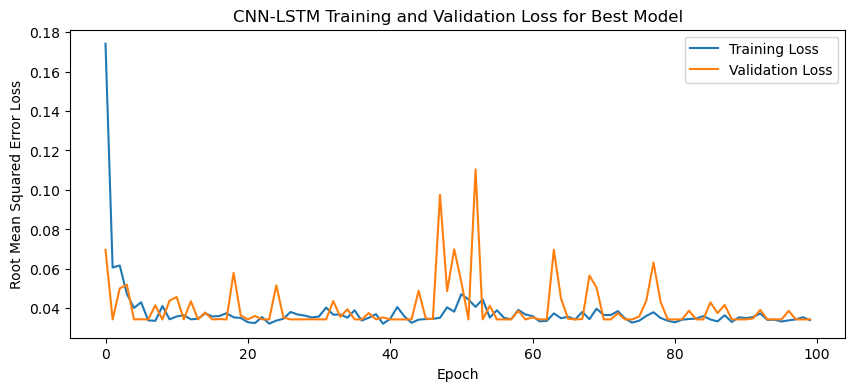

1/1 - 1s - loss: 0.0271 - 1s/epoch - 1s/step
Test Loss: 0.027079463005065918
1/1 [==============================] - 0s 33ms/step


NameError: name 'series' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model

# make forecast with the CNN-LSTM best model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    rmse_list = []
    mae_list = []
    mape_list = []
    r2_list = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)
        r2 = r2_score(actual, predicted) 
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)
        r2_list.append(r2)
        print("Month at t+"+str(i+1)+":")
        print('t+%d RMSE: %f' % ((i+1), rmse))
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d MAPE: %f' % ((i+1), mape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))

    return rmse_list, mae_list, mape_list, r2_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test+2, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test+2, n_seq)

    rmse_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores root mean squared errors for each future time prediction
    mape_list = [] # list stores root mean squared errors for each future time prediction
    r2_list = [] # list stores root mean squared errors for each future time prediction
    
    # evaluate forecasts
    rmse_list, mae_list, mape_list, r2_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    for j in range(len(X_test)):
        print("Weather Station "+str(j+1)+":")
        dataset_df = pd.DataFrame(y_test[j].flatten())
        dataset = dataset_df.values
        dataset = dataset[:, 0]
        dataset = np.array(dataset).reshape(-1, 1)
        dataset = dataset.flatten()
        dataset = pd.DataFrame(dataset)
        series = scaler[i].inverse_transform(dataset)
        series = pd.Series(series.flatten())

    # plot forecasts
    plot_forecasts(series, forecasts, 1)
    
    best_model.summary()

    # Print out table of actual and predicted values for each weather station
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

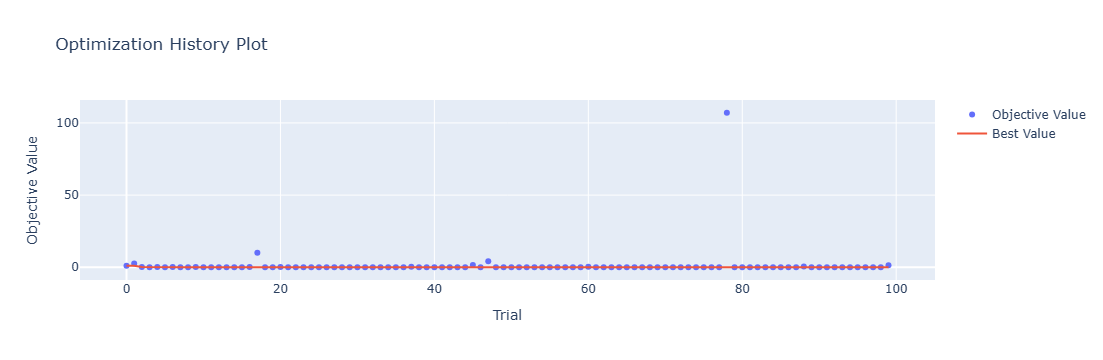

In [4]:
optuna.visualization.plot_optimization_history(study)

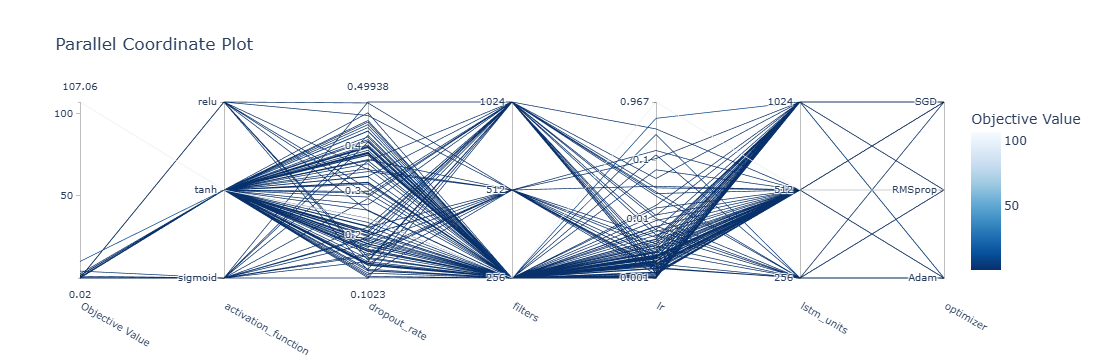

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

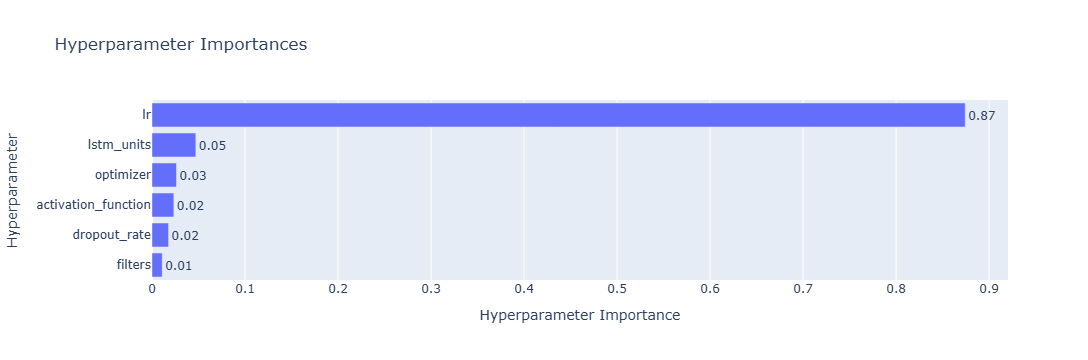

In [6]:
optuna.visualization.plot_param_importances(study)

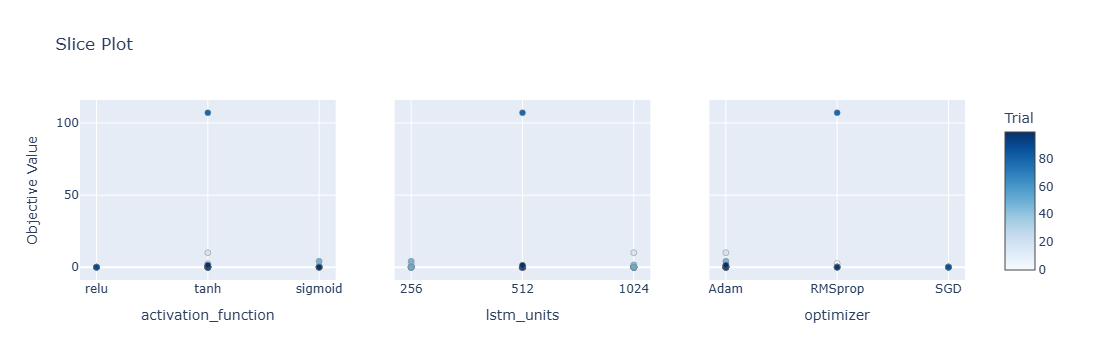

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

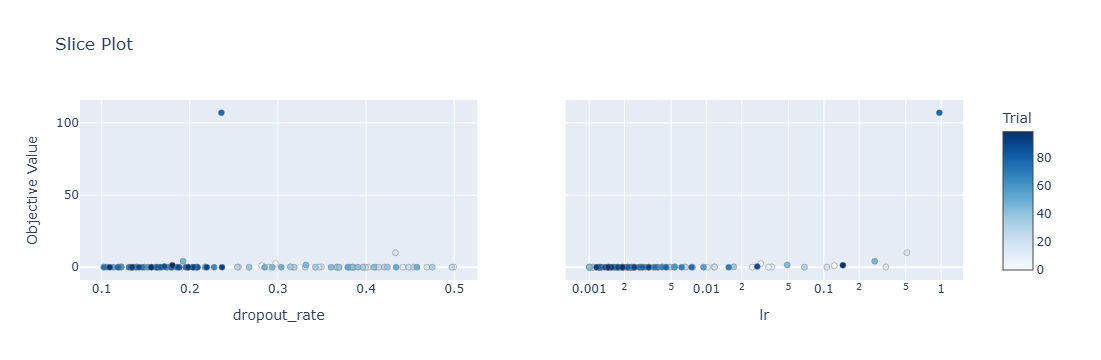

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.21  8.17 15.68 ... 23.86 20.59 15.82]
 [14.52 12.85 16.77 ... 26.49 23.17 21.15]
 [ 8.91  6.23 11.39 ... 22.62 16.72 14.05]
 ...
 [ 7.87  5.76 10.62 ... 21.07 15.24 12.04]
 [ 6.49  2.73  9.77 ... 21.93 16.5  11.44]
 [ 5.29  1.27  5.84 ... 22.11 15.37  9.87]]
Epoch 1/100
84/84 [==============================] - 36s 147ms/step - loss: 0.1279 - accuracy: 0.0000e+00 - mae: 0.1279 - rmse: 0.1279 - mape: 27.1734 - pearson: nan - val_loss: 0.0877 - val_accuracy: 0.0000e+00 - val_mae: 0.0877 - val_rmse: 0.0877 - val_mape: 19.8673 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 6s 70ms/step - loss: 0.0824 - accuracy: 0.0000e+00 - mae: 0.0824 - rmse: 0.0824 - mape: 17.4386 - pearson: nan - val_loss: 0.1247 - val_accuracy: 0.0000e+00 - val_mae: 0.1247 - val_rmse: 0.1247 - val_mape: 26.6584 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 6s 76ms/step - loss: 0.0617 - accuracy: 0.0000e+00 - mae: 0.0617 - rmse: 0.0617 - mape: 12.9955 - pearson: na

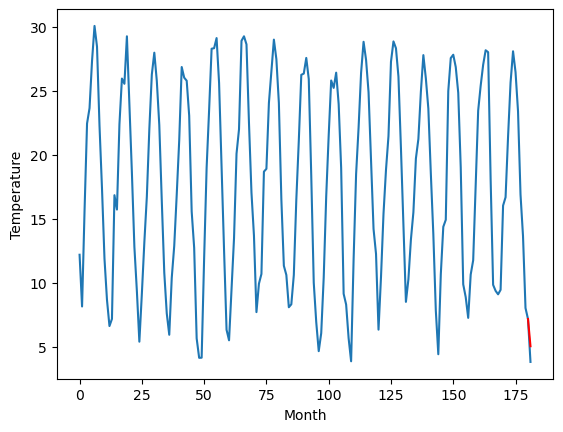

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.87		11.99		-0.88
[180, 181]
[13.23, 11.985936231017114]


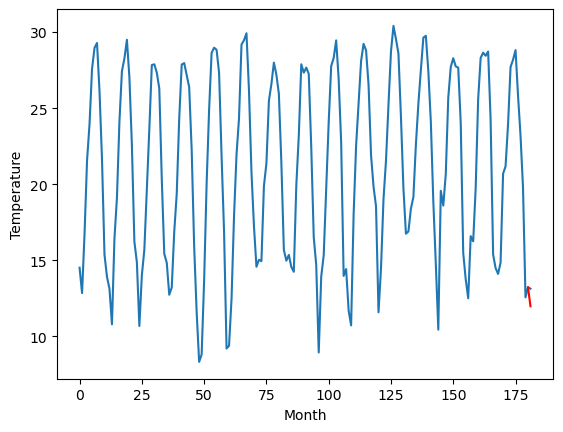

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.34		14.30		-1.04
[180, 181]
[7.18, 14.295936231017112]


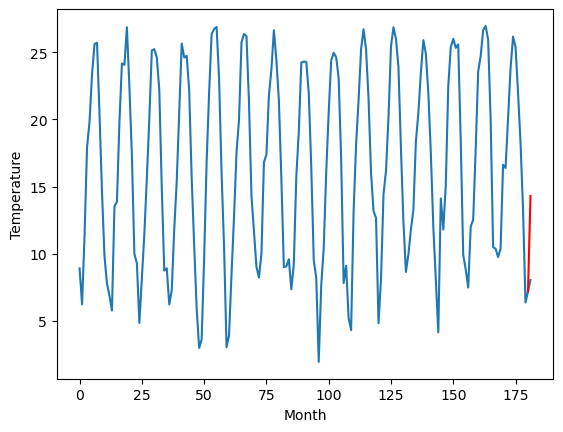

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.00		8.69		-0.31
[180, 181]
[11.46, 8.685936231017113]


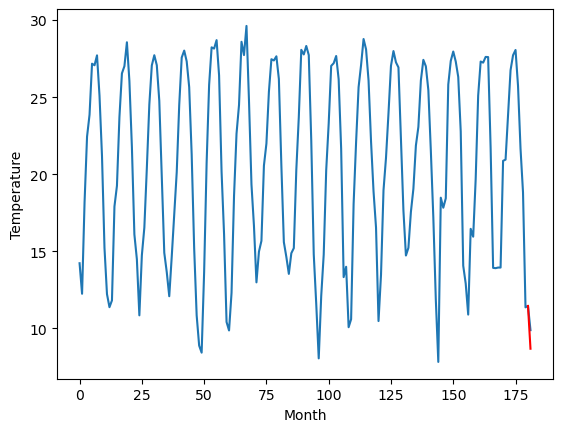

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		14.01		0.66
[180, 181]
[9.27, 14.005936231017113]


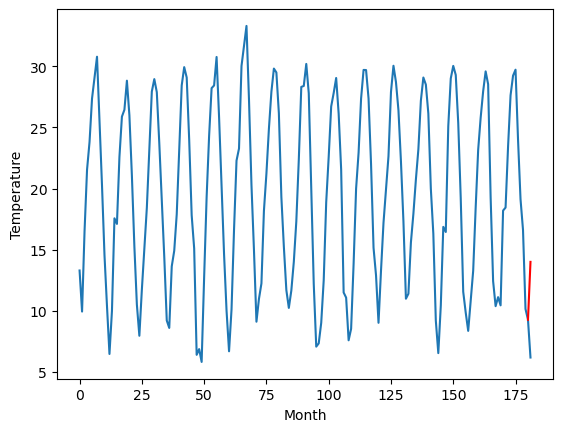

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.52		13.08		1.56
[180, 181]
[7.77, 13.075936231017113]


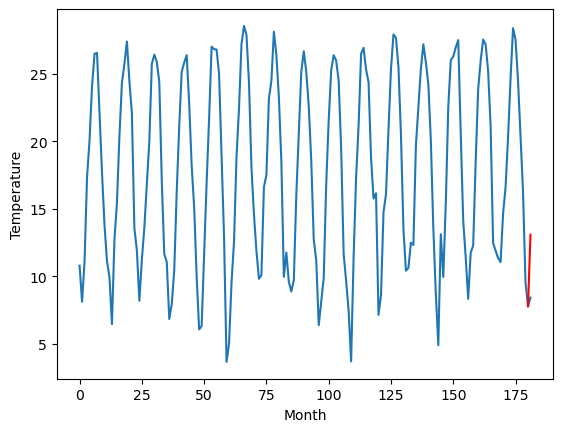

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.21		10.57		0.36
[180, 181]
[6.59, 10.565936231017112]


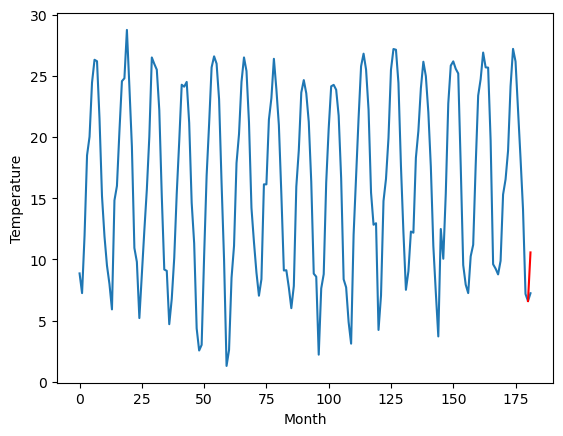

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.91		8.63		0.72
[180, 181]
[5.3, 8.625936231017112]


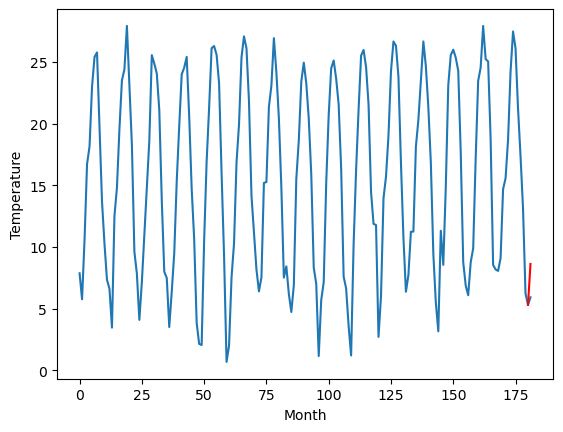

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.08		7.65		0.57
[180, 181]
[3.1, 7.645936231017113]


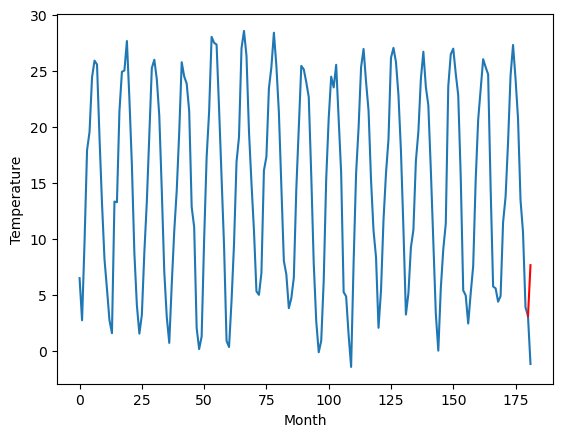

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
4.90		6.27		1.37
[180, 181]
[0.6, 6.265936231017113]


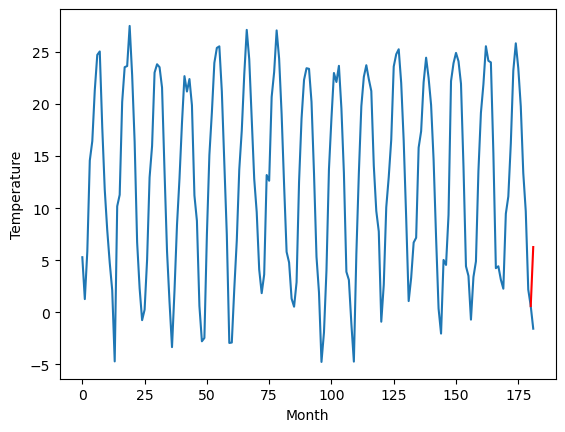

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.68		5.07		1.39
[180, 181]
[-0.75, 5.065936231017113]


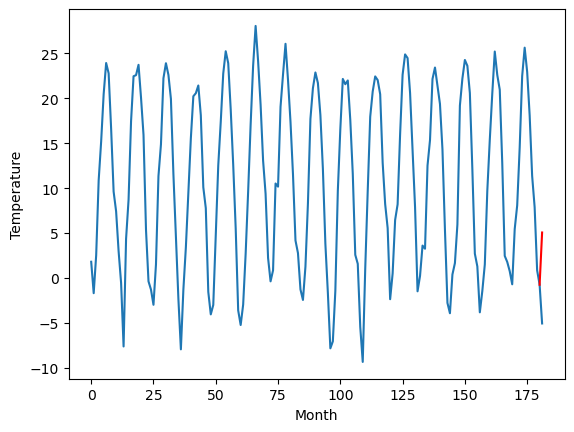

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    4.43   5.065936
1                 1   12.87  11.985936
2                 2   15.34  14.295936
3                 3    9.00   8.685936
4                 4   13.35  14.005936
5                 5   11.52  13.075936
6                 6   10.21  10.565936
7                 7    7.91   8.625936
8                 8    7.08   7.645936
9                 9    4.90   6.265936
10               10    3.68   5.065936


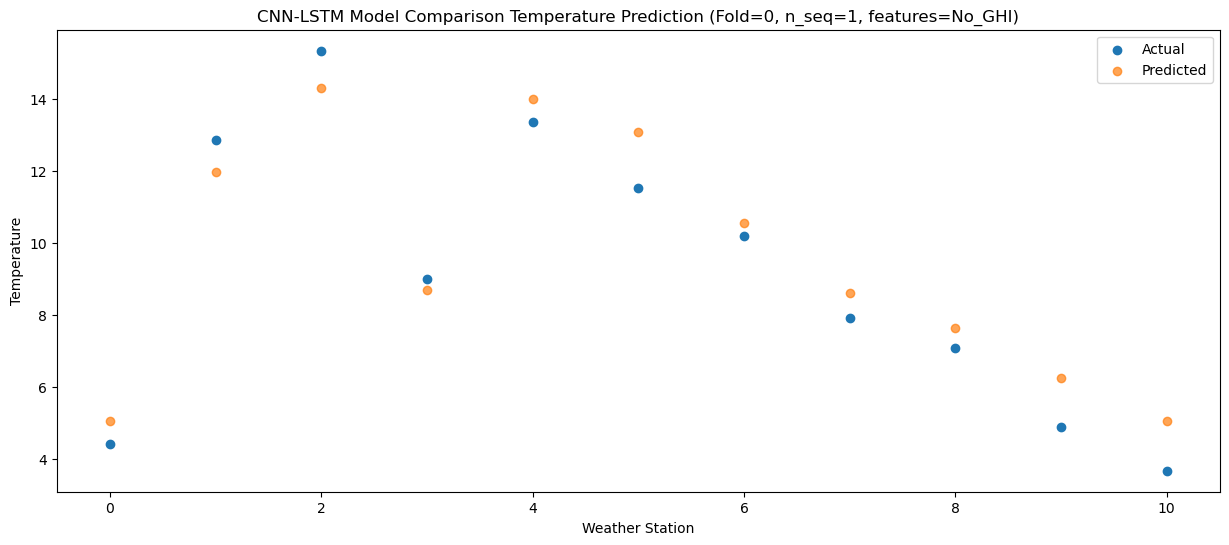

f, t:
[[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68]]
[[ 5.06593623 11.98593623 14.29593623  8.68593623 14.00593623 13.07593623
  10.56593623  8.62593623  7.64593623  6.26593623  5.06593623]]
Year at t+1:
t+1 SKRMSE: 0.952128
t+1 KRMSE: 0.952128
t+1 MAE: 0.861789
t+1 SKMAPE: 0.123644
t+1 R2_SCORE: 0.934665
t+1 KMAPE: 0.123644
t+1 PEARSON: 0.959594
t+1 AVERAGE ACTUAL: 9.117273
Metrics for this Fold:
SKRMSE: 0.952128
KRMSE: 0.952128
MAE: 0.861789
SKMAPE: 0.123644
R2_SCORE: 0.934665
KMAPE: 0.123644
PEARSON: 0.959594
AVERAGE ACTUAL: 9.117273
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            1008640   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 512)           0         
 )                                                               
                  

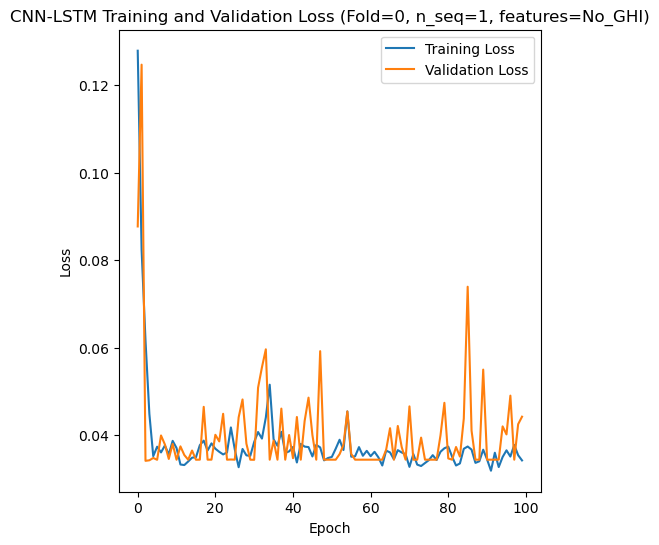

[[12.2  10.03 13.86 ... 24.46 19.58 17.03]
 [ 8.35  6.22 11.74 ... 22.47 18.02 13.98]
 [10.82  7.37 13.36 ... 24.57 19.57 16.15]
 ...
 [ 7.69  4.56 11.66 ... 25.3  19.83 13.28]
 [ 8.93  6.7  14.14 ... 25.37 21.51 12.55]
 [ 7.96  5.46 11.14 ... 25.13 20.28 10.63]]
Epoch 1/100
84/84 [==============================] - 35s 148ms/step - loss: 0.1573 - accuracy: 0.0000e+00 - mae: 0.1573 - rmse: 0.1573 - mape: 33.6830 - pearson: nan - val_loss: 0.0840 - val_accuracy: 0.0000e+00 - val_mae: 0.0840 - val_rmse: 0.0840 - val_mape: 18.2282 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 7s 87ms/step - loss: 0.0936 - accuracy: 0.0000e+00 - mae: 0.0936 - rmse: 0.0936 - mape: 19.7588 - pearson: nan - val_loss: 0.0255 - val_accuracy: 0.0000e+00 - val_mae: 0.0255 - val_rmse: 0.0255 - val_mape: 5.4865 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 8s 93ms/step - loss: 0.0686 - accuracy: 0.0000e+00 - mae: 0.0686 - rmse: 0.0686 - mape: 14.2232 - pearson: nan

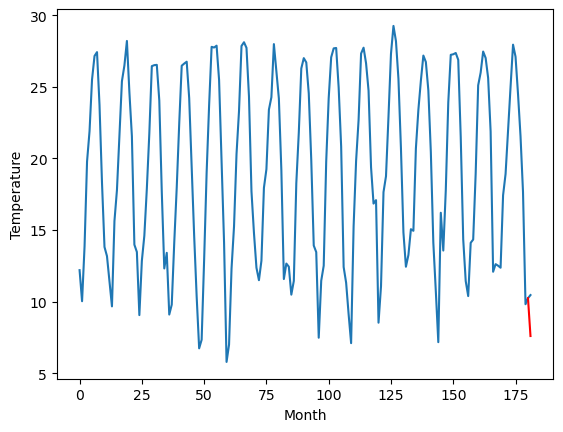

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.00		11.84		-0.16
[180, 181]
[6.41, 11.838923317193984]


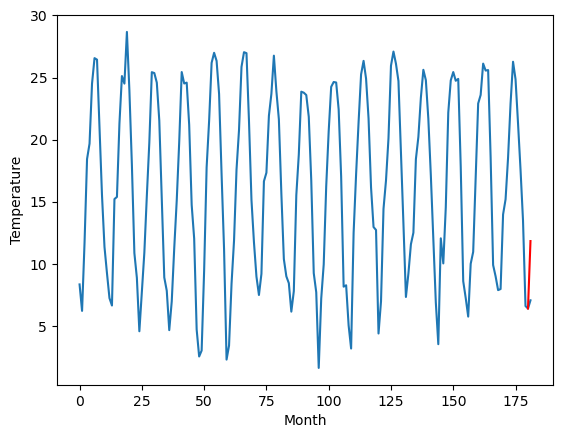

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.77		7.99		-0.78
[180, 181]
[7.6, 7.988923317193985]


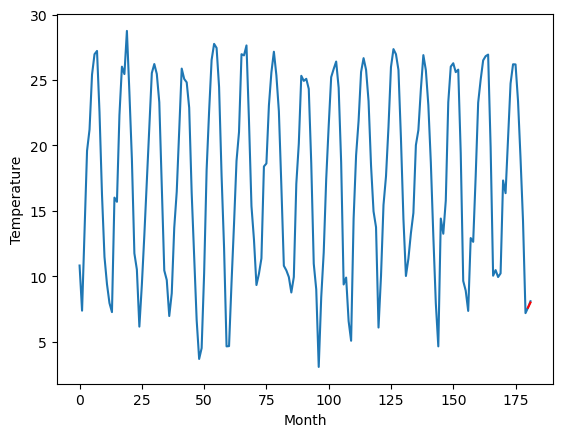

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.72		10.46		-0.26
[180, 181]
[11.89, 10.458924300670624]


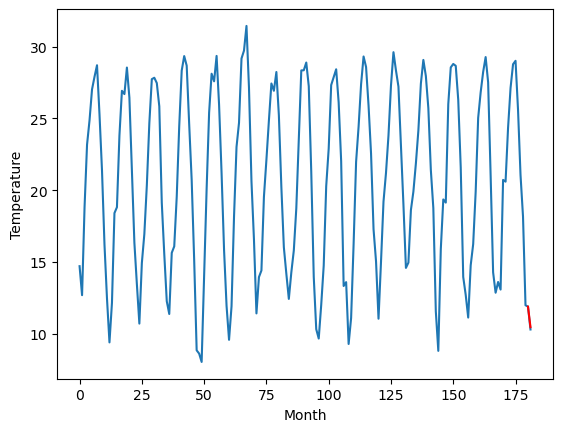

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.70		14.35		-0.35
[180, 181]
[10.96, 14.348923317193986]


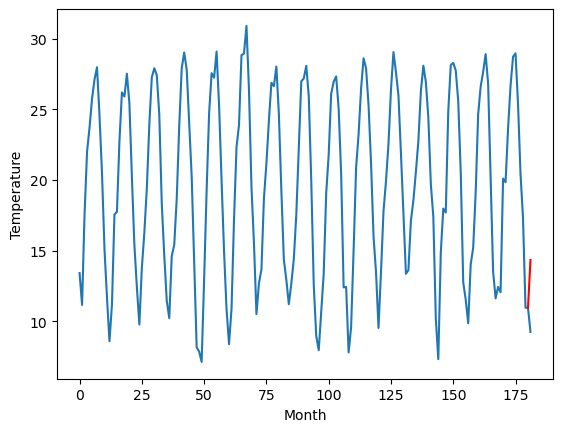

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.91		13.06		1.15
[180, 181]
[7.75, 13.058924300670624]


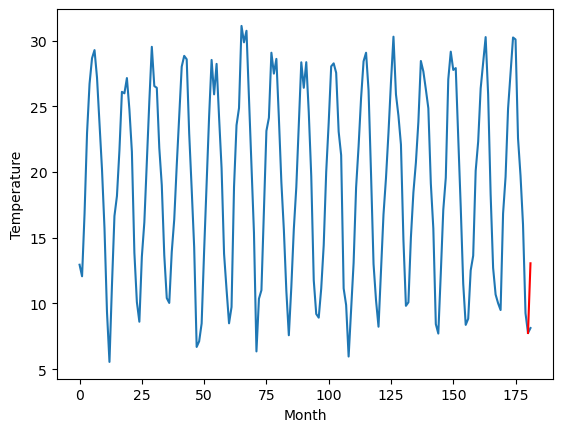

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.75		12.59		-0.16
[180, 181]
[6.17, 12.588924300670623]


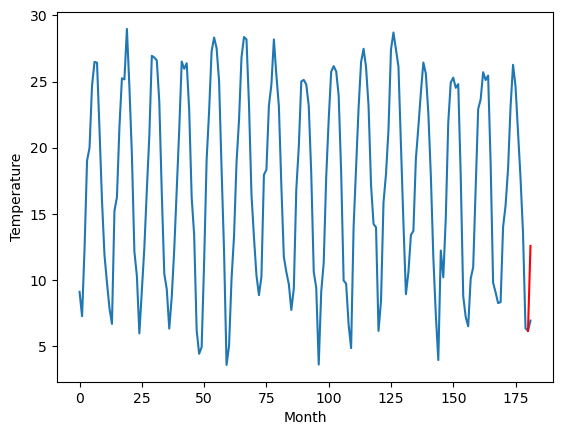

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.81		8.76		-0.05
[180, 181]
[4.57, 8.758923317193984]


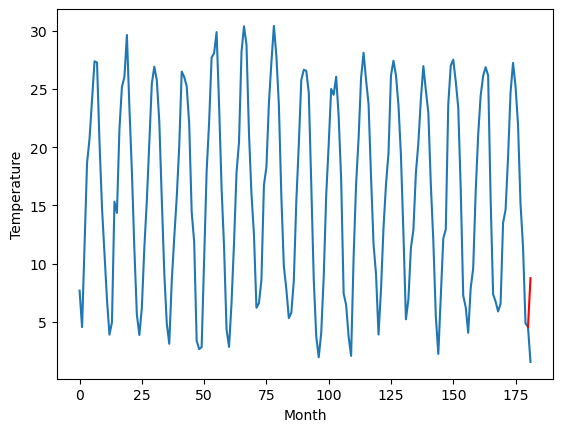

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.34		7.33		-0.01
[180, 181]
[5.46, 7.328923317193985]


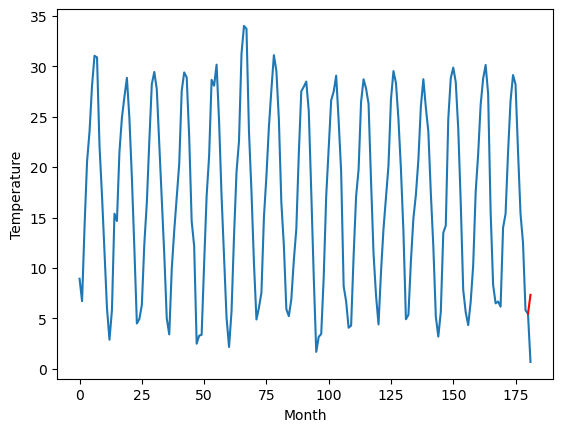

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
9.04		8.57		-0.47
[180, 181]
[5.42, 8.568923317193985]


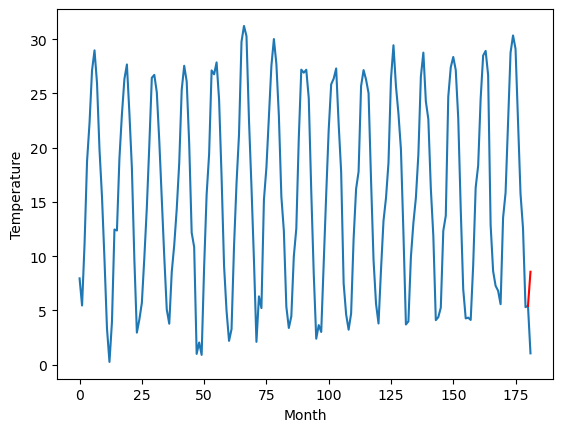

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.12		7.60		1.48
[180, 181]
[2.17, 7.598922333717346]


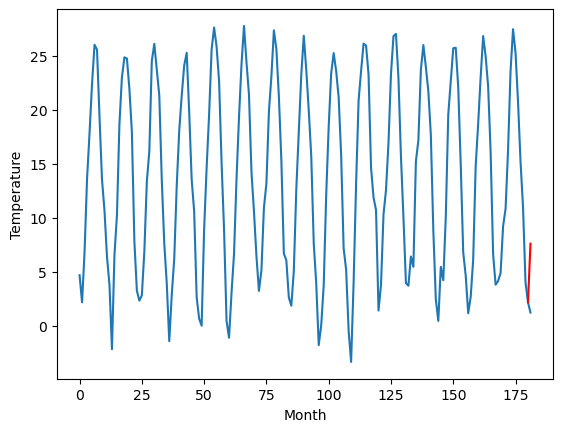

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.38   7.598924
1                 1   12.00  11.838923
2                 2    8.77   7.988923
3                 3   10.72  10.458924
4                 4   14.70  14.348923
5                 5   11.91  13.058924
6                 6   12.75  12.588924
7                 7    8.81   8.758923
8                 8    7.34   7.328923
9                 9    9.04   8.568923
10               10    6.12   7.598922


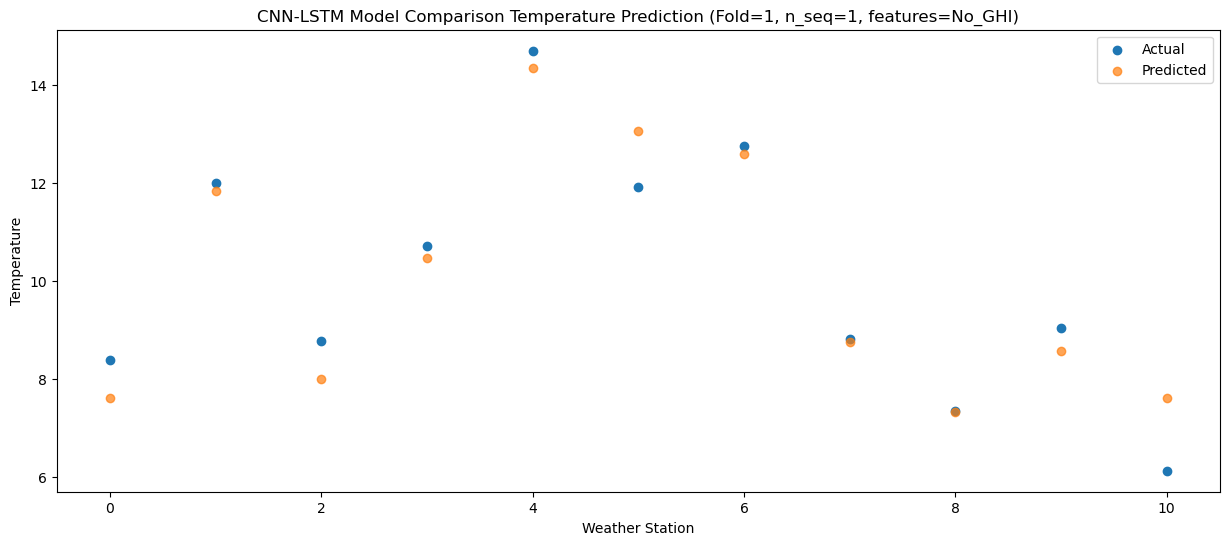

f, t:
[[ 8.38 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12]]
[[ 7.5989243  11.83892332  7.98892332 10.4589243  14.34892332 13.0589243
  12.5889243   8.75892332  7.32892332  8.56892332  7.59892233]]
Year at t+1:
t+1 SKRMSE: 0.687244
t+1 KRMSE: 0.687244
t+1 MAE: 0.514321
t+1 SKMAPE: 0.059464
t+1 R2_SCORE: 0.921754
t+1 KMAPE: 0.059464
t+1 PEARSON: 0.922746
t+1 AVERAGE ACTUAL: 10.049091
Metrics for this Fold:
SKRMSE: 0.687244
KRMSE: 0.687244
MAE: 0.514321
SKMAPE: 0.059464
R2_SCORE: 0.921754
KMAPE: 0.059464
PEARSON: 0.922746
AVERAGE ACTUAL: 10.049091
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
               

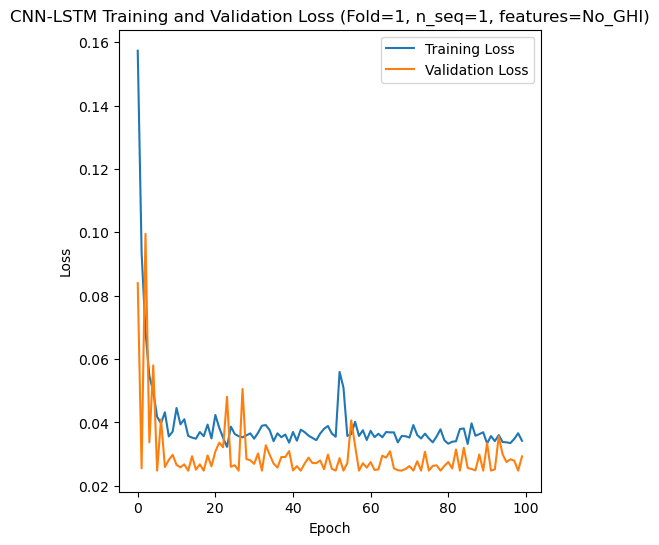

[[ 8.61  4.71 12.22 ... 22.49 18.22 13.52]
 [ 6.28  3.18  8.73 ... 22.36 17.39  7.52]
 [17.82 16.52 20.35 ... 28.79 25.32 22.93]
 ...
 [ 6.77  9.55 12.16 ... 24.55 20.29 10.24]
 [12.04 12.81 10.78 ... 23.32 20.33 13.93]
 [ 8.57  6.56 11.36 ... 21.36 16.14 12.65]]
Epoch 1/100
84/84 [==============================] - 53s 279ms/step - loss: 0.1373 - accuracy: 0.0000e+00 - mae: 0.1373 - rmse: 0.1373 - mape: 29.1665 - pearson: nan - val_loss: 0.2134 - val_accuracy: 0.0000e+00 - val_mae: 0.2134 - val_rmse: 0.2134 - val_mape: 47.6436 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 15s 182ms/step - loss: 0.0878 - accuracy: 0.0000e+00 - mae: 0.0878 - rmse: 0.0878 - mape: 18.6000 - pearson: nan - val_loss: 0.0361 - val_accuracy: 0.0000e+00 - val_mae: 0.0361 - val_rmse: 0.0361 - val_mape: 8.2386 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 15s 184ms/step - loss: 0.0688 - accuracy: 0.0000e+00 - mae: 0.0688 - rmse: 0.0688 - mape: 14.5033 - pearson:

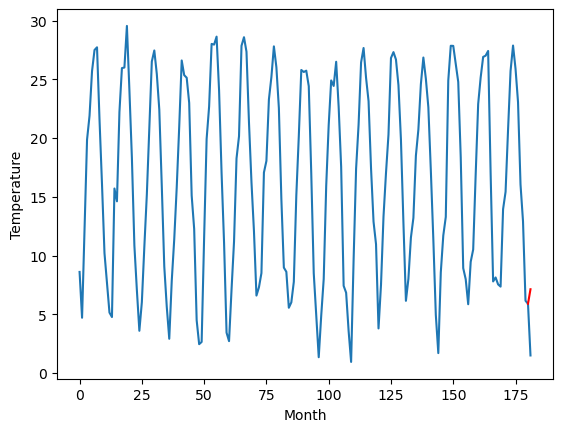

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.53		7.18		-1.35
[180, 181]
[2.63, 7.176164851188659]


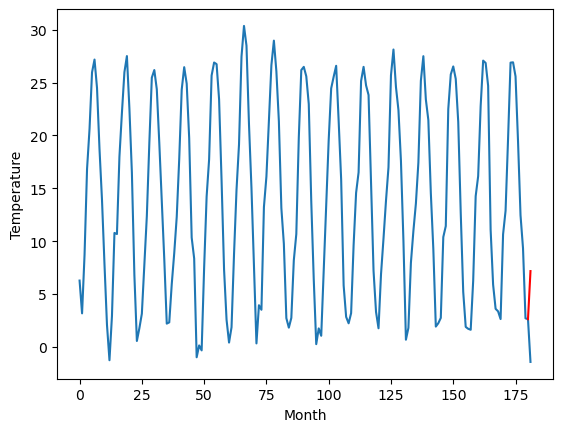

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.94		4.85		-2.09
[180, 181]
[16.55, 4.846165924072266]


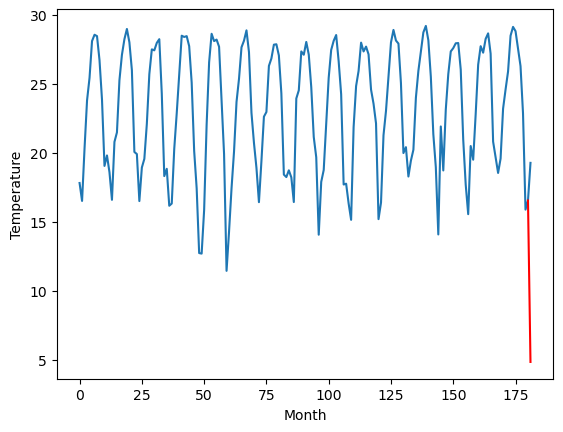

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
14.74		16.39		1.65
[180, 181]
[-0.83, 16.38616485118866]


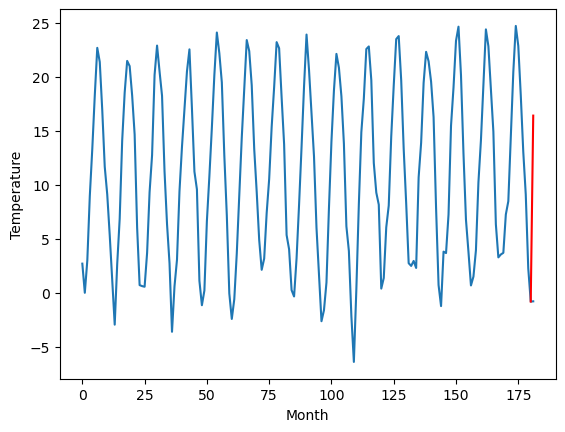

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
3.03		1.25		-1.78
[180, 181]
[11.52, 1.2461659240722658]


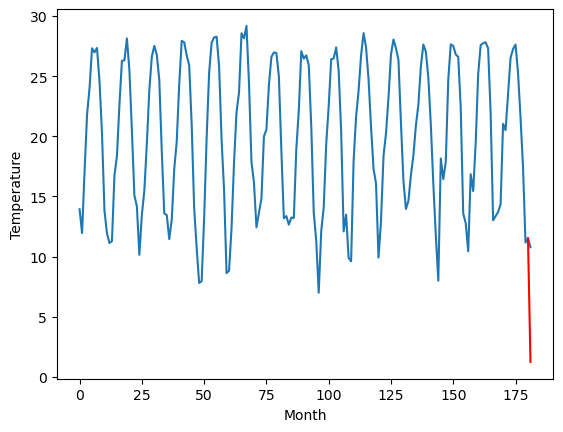

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		12.51		-0.84
[180, 181]
[11.47, 12.50616485118866]


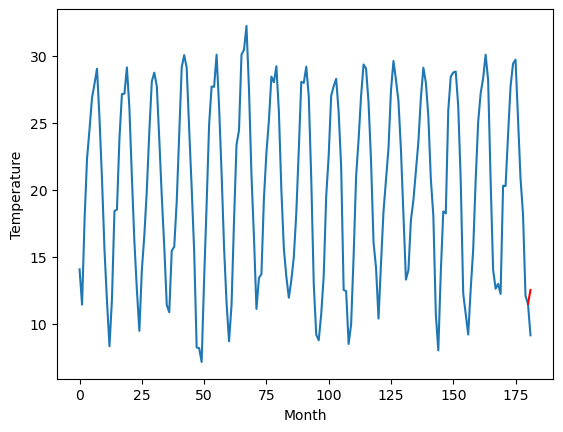

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.35		12.62		-0.73
[180, 181]
[7.75, 12.61616485118866]


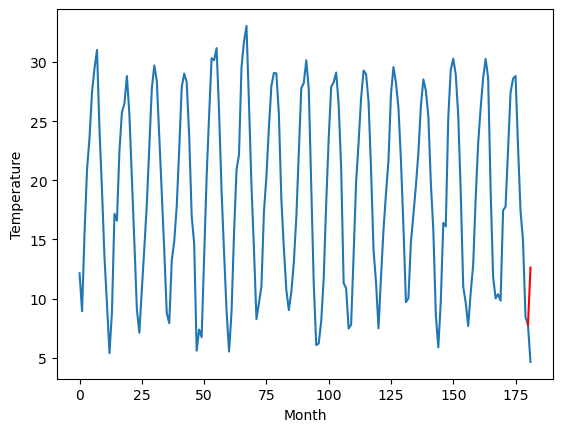

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.68		10.71		-1.97
[180, 181]
[4.9, 10.70616485118866]


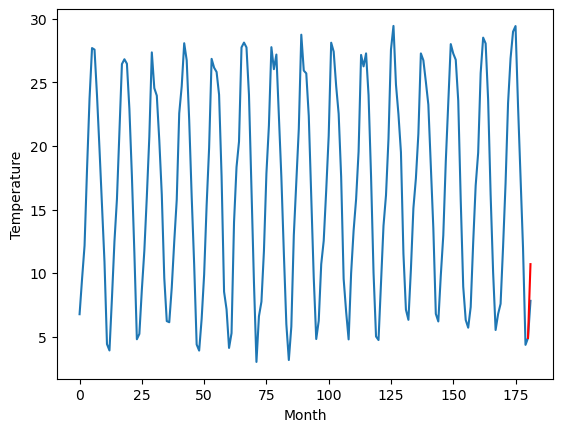

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.71		5.34		-1.37
[180, 181]
[14.14, 5.336165924072265]


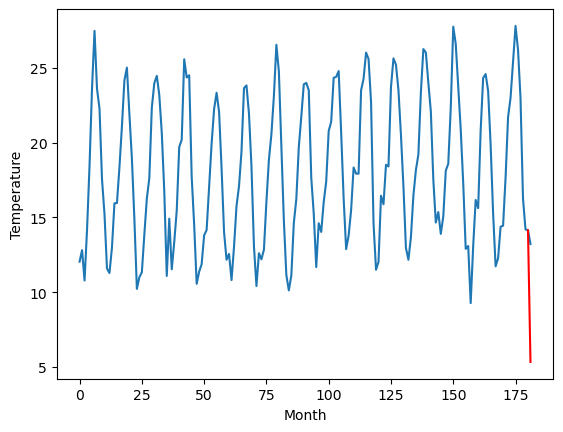

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
11.63		10.61		-1.02
[180, 181]
[5.55, 10.606165924072265]


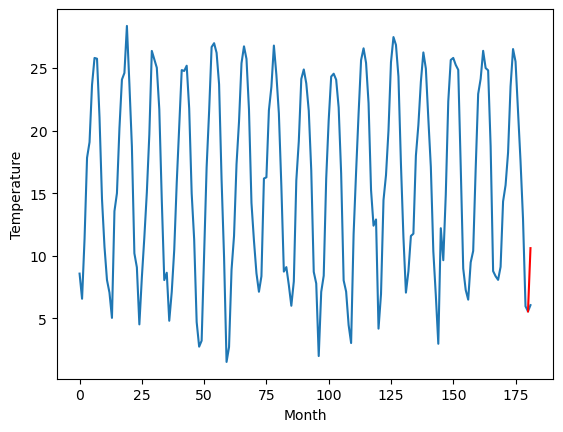

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.90		7.14		-1.76
[180, 181]
[3.19, 7.13616485118866]


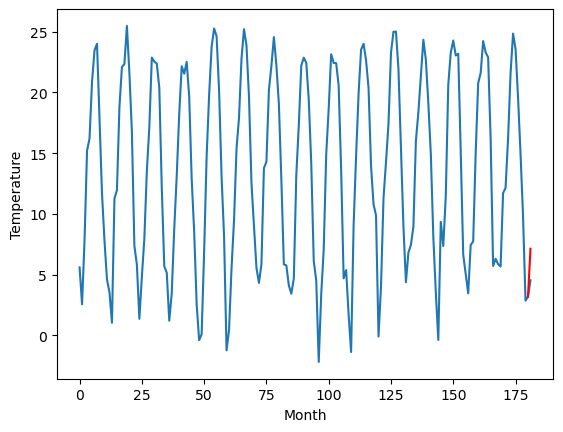

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    8.31   7.136165
1                 1    8.53   7.176165
2                 2    6.94   4.846166
3                 3   14.74  16.386165
4                 4    3.03   1.246166
5                 5   13.35  12.506165
6                 6   13.35  12.616165
7                 7   12.68  10.706165
8                 8    6.71   5.336166
9                 9   11.63  10.606166
10               10    8.90   7.136165


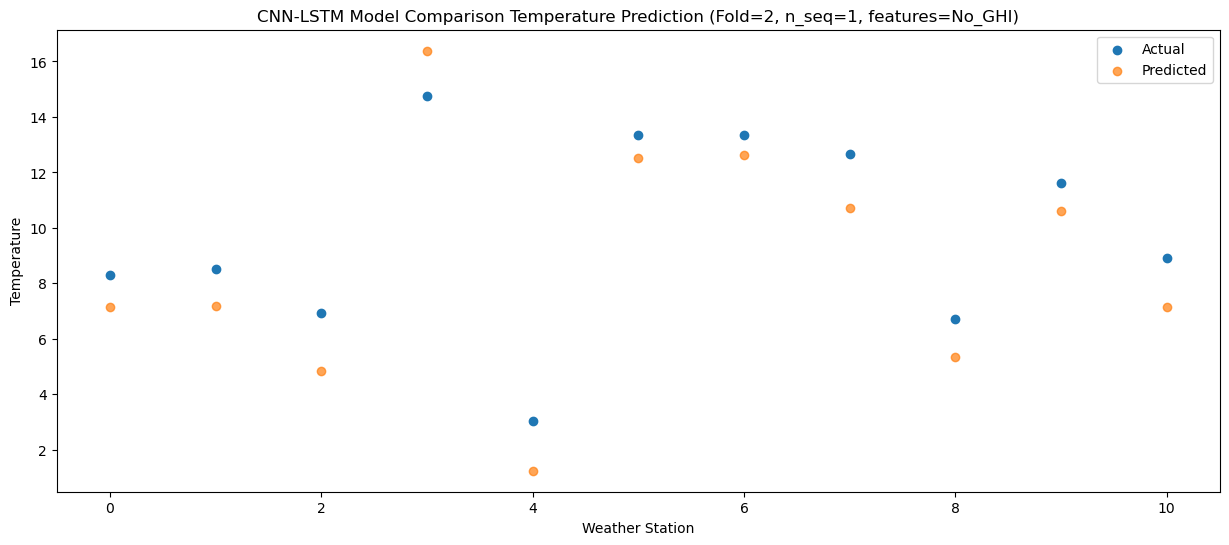

f, t:
[[ 8.31  8.53  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9 ]]
[[ 7.13616485  7.17616485  4.84616592 16.38616485  1.24616592 12.50616485
  12.61616485 10.70616485  5.33616592 10.60616592  7.13616485]]
Year at t+1:
t+1 SKRMSE: 1.497883
t+1 KRMSE: 1.497883
t+1 MAE: 1.433137
t+1 SKMAPE: 0.187899
t+1 R2_SCORE: 0.809336
t+1 KMAPE: 0.187899
t+1 PEARSON: 0.964758
t+1 AVERAGE ACTUAL: 9.833636
Metrics for this Fold:
SKRMSE: 1.497883
KRMSE: 1.497883
MAE: 1.433137
SKMAPE: 0.187899
R2_SCORE: 0.809336
KMAPE: 0.187899
PEARSON: 0.964758
AVERAGE ACTUAL: 9.833636
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                

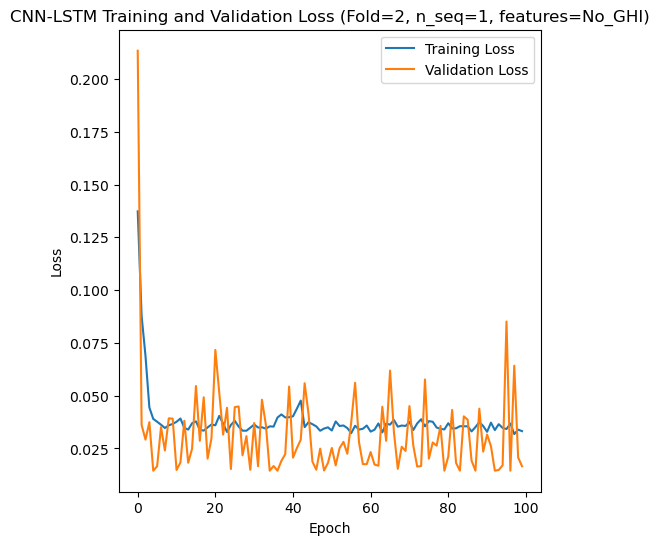

[[ 8.9   6.89 11.3  ... 22.19 16.88 13.54]
 [ 7.02  3.15 10.24 ... 22.31 18.92 11.32]
 [ 7.65  9.7   9.44 ... 25.68 20.65 11.46]
 ...
 [ 9.57 11.93 12.22 ... 30.9  25.01 12.37]
 [ 9.04  9.3   8.59 ... 17.72 17.26 10.73]
 [ 3.2   0.4   3.78 ... 18.92 14.39 10.04]]
Epoch 1/100
84/84 [==============================] - 53s 277ms/step - loss: 0.1279 - accuracy: 0.0000e+00 - mae: 0.1279 - rmse: 0.1279 - mape: 28.5385 - pearson: nan - val_loss: 0.0656 - val_accuracy: 0.0000e+00 - val_mae: 0.0656 - val_rmse: 0.0656 - val_mape: 13.3781 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 15s 182ms/step - loss: 0.0678 - accuracy: 0.0000e+00 - mae: 0.0678 - rmse: 0.0678 - mape: 15.1799 - pearson: nan - val_loss: 0.0863 - val_accuracy: 0.0000e+00 - val_mae: 0.0863 - val_rmse: 0.0863 - val_mape: 17.9595 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 15s 182ms/step - loss: 0.0679 - accuracy: 0.0000e+00 - mae: 0.0679 - rmse: 0.0679 - mape: 15.0806 - pearson

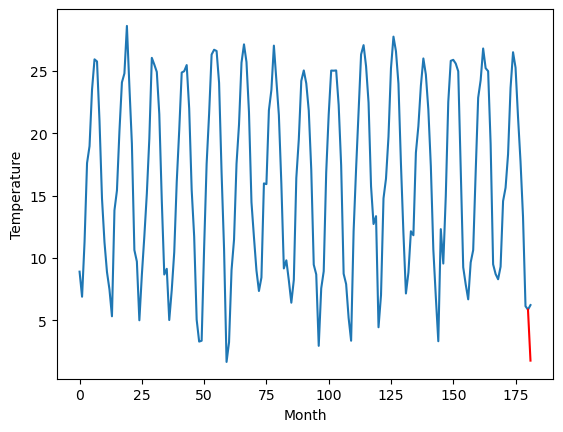

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.75		7.46		-0.29
[180, 181]
[3.2, 7.46443190574646]


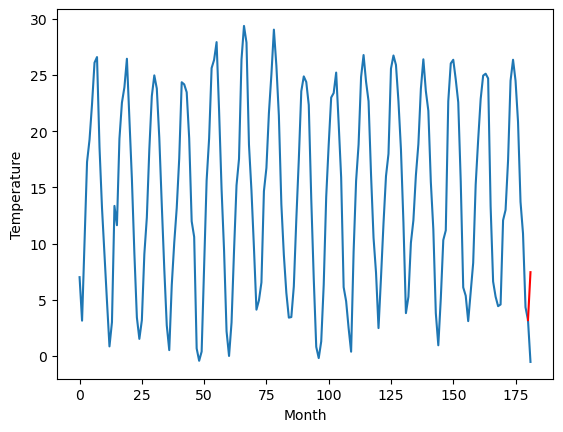

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
8.28		5.58		-2.70
[180, 181]
[8.48, 5.584435601234436]


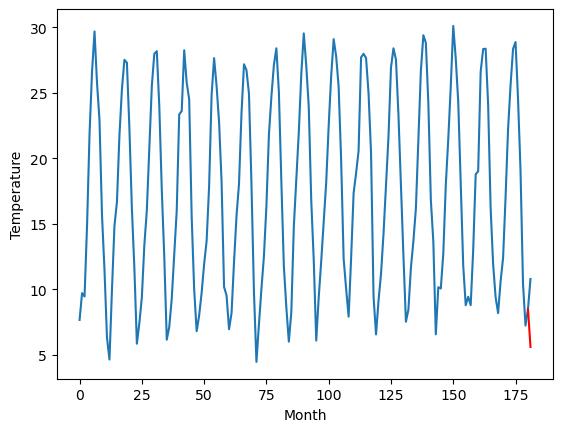

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.19		6.21		0.02
[180, 181]
[1.55, 6.214396977424622]


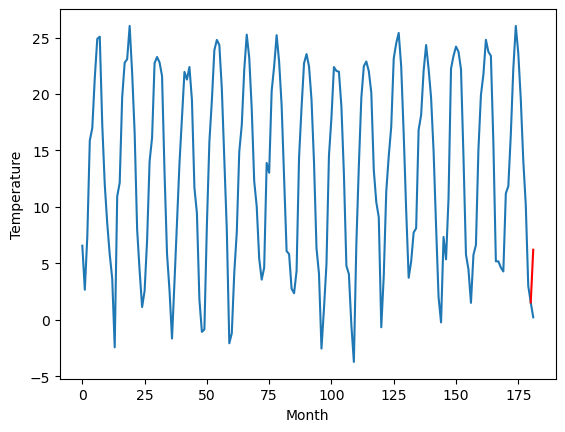

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.10		5.13		0.03
[180, 181]
[1.08, 5.134378142356873]


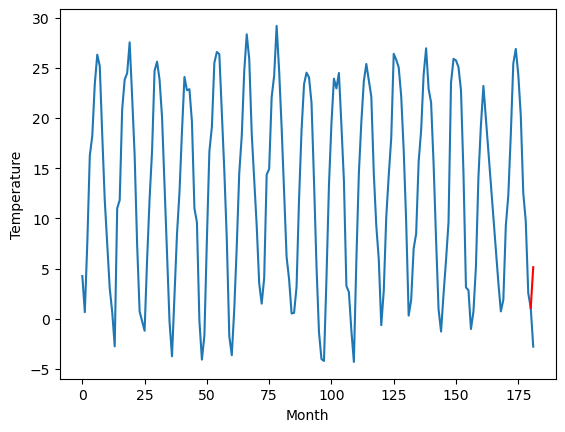

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.80		2.81		0.01
[180, 181]
[0.21, 2.8143941164016724]


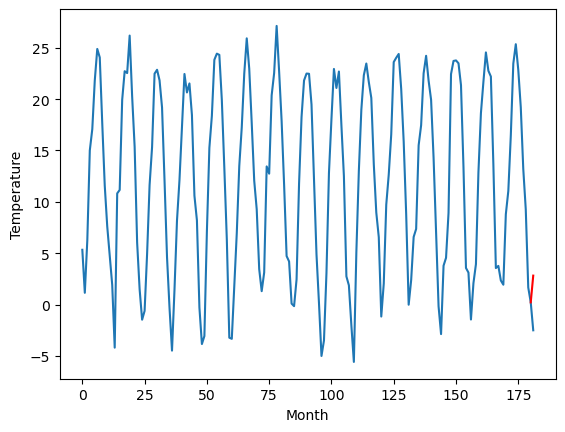

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.60		3.89		-1.71
[180, 181]
[-8.22, 3.894416766166687]


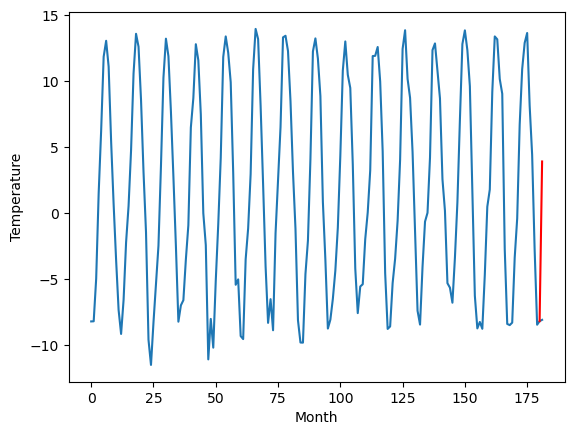

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
-7.69		-9.68		-1.99
[180, 181]
[10.04, -9.675572862625122]


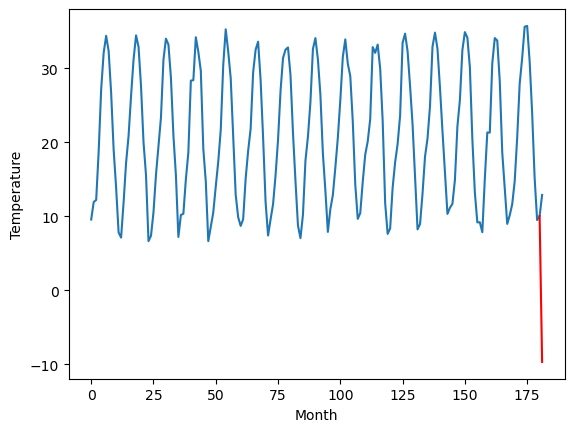

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		8.13		-2.66
[180, 181]
[9.17, 8.134467787742615]


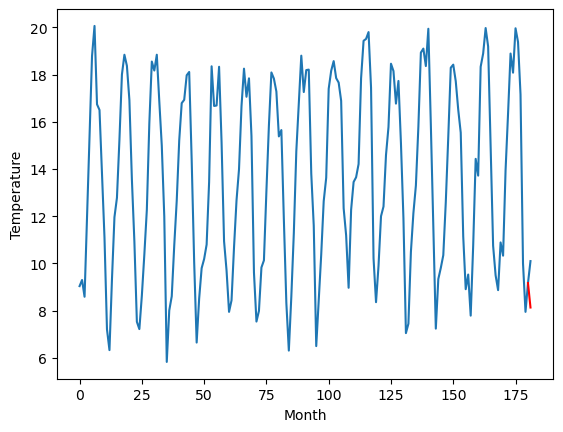

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.02		7.60		1.58
[180, 181]
[0.94, 7.604379930496215]


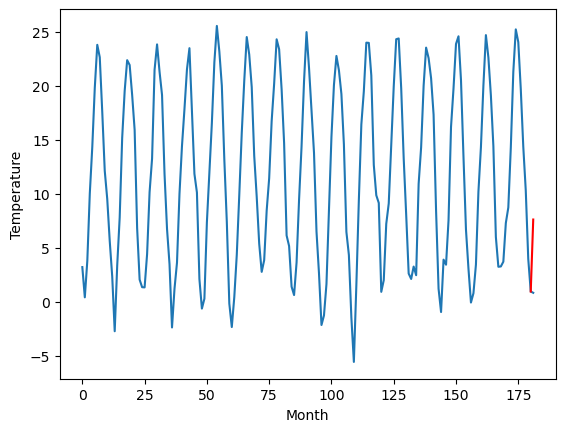

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.64		1.76		0.12
[180, 181]
[-0.13, 1.7643724203109743]


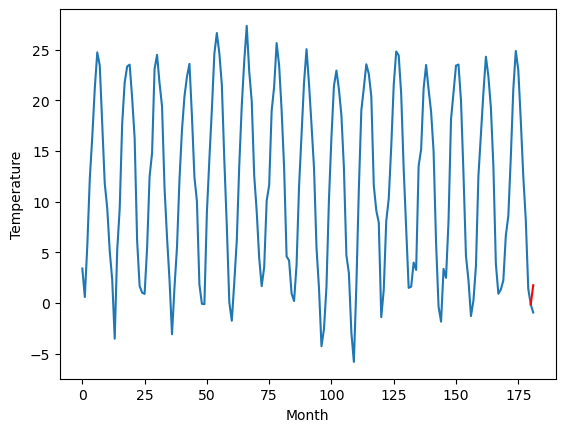

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.92   1.764396
1                 1    7.75   7.464432
2                 2    8.28   5.584436
3                 3    6.19   6.214397
4                 4    5.10   5.134378
5                 5    2.80   2.814394
6                 6    5.60   3.894417
7                 7   -7.69  -9.675573
8                 8   10.79   8.134468
9                 9    6.02   7.604380
10               10    1.64   1.764372


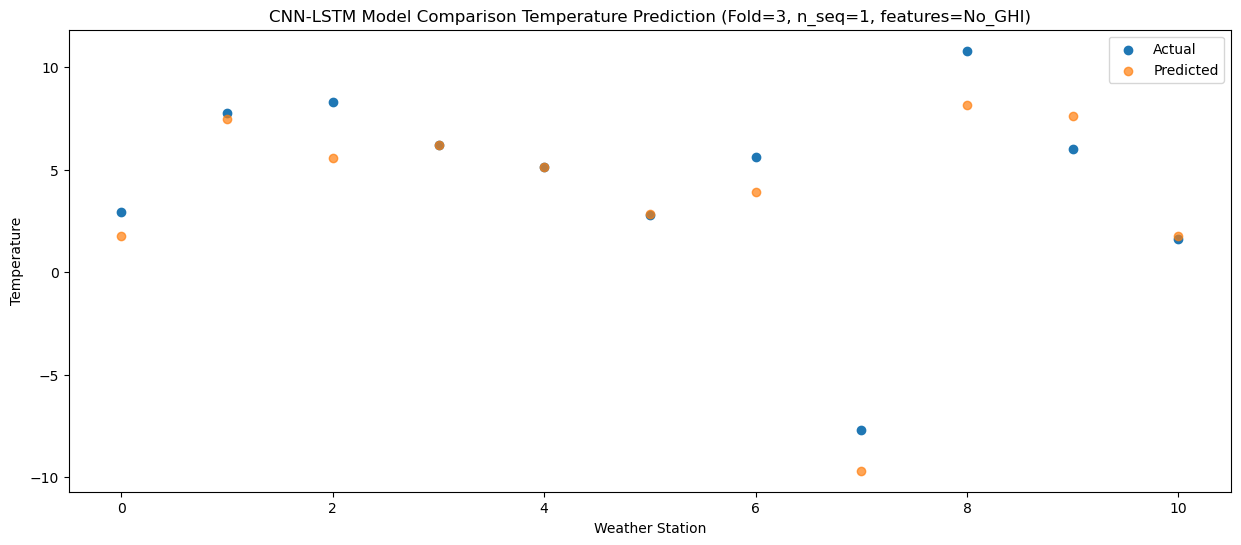

f, t:
[[ 2.92  7.75  8.28  6.19  5.1   2.8   5.6  -7.69 10.79  6.02  1.64]]
[[ 1.76439602  7.46443191  5.5844356   6.21439698  5.13437814  2.81439412
   3.89441677 -9.67557286  8.13446779  7.60437993  1.76437242]]
Year at t+1:
t+1 SKRMSE: 1.510993
t+1 KRMSE: 1.510993
t+1 MAE: 1.115031
t+1 SKMAPE: 0.174716
t+1 R2_SCORE: 0.892359
t+1 KMAPE: 0.127771
t+1 PEARSON: 0.926605
t+1 AVERAGE ACTUAL: 4.490909
Metrics for this Fold:
SKRMSE: 1.510993
KRMSE: 1.510993
MAE: 1.115031
SKMAPE: 0.174716
R2_SCORE: 0.892359
KMAPE: 0.127771
PEARSON: 0.926605
AVERAGE ACTUAL: 4.490909
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                

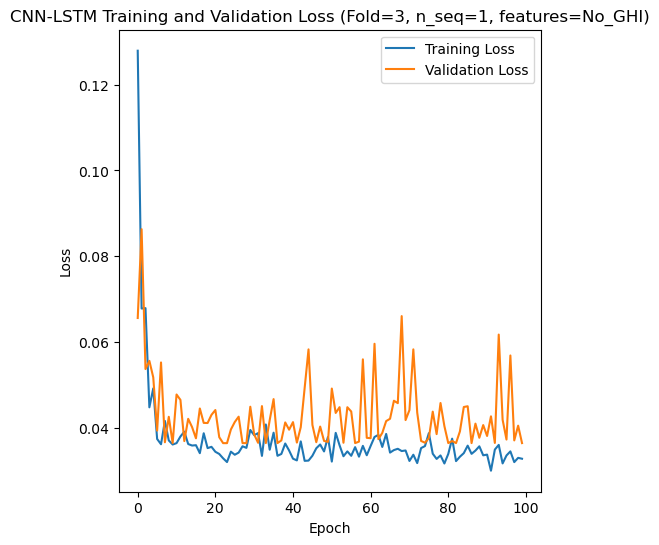

[[ 4.89  1.26  7.78 ... 22.59 18.46  9.82]
 [15.38 13.87 17.63 ... 26.66 22.89 20.2 ]
 [11.49  8.39 14.48 ... 24.97 20.83 17.82]
 ...
 [ 7.64  3.61 10.44 ... 21.3  17.62 11.34]
 [ 4.26  0.29  5.21 ... 21.47 15.54  9.34]
 [ 3.62 -0.32  6.05 ... 19.99 14.92  8.29]]
Epoch 1/100
84/84 [==============================] - 46s 253ms/step - loss: 0.1523 - accuracy: 0.0000e+00 - mae: 0.1523 - rmse: 0.1523 - mape: 32.4583 - pearson: nan - val_loss: 0.1399 - val_accuracy: 0.0000e+00 - val_mae: 0.1399 - val_rmse: 0.1399 - val_mape: 28.5504 - val_pearson: nan
Epoch 2/100
84/84 [==============================] - 15s 173ms/step - loss: 0.0792 - accuracy: 0.0000e+00 - mae: 0.0792 - rmse: 0.0792 - mape: 16.6404 - pearson: nan - val_loss: 0.0476 - val_accuracy: 0.0000e+00 - val_mae: 0.0476 - val_rmse: 0.0476 - val_mape: 10.5045 - val_pearson: nan
Epoch 3/100
84/84 [==============================] - 15s 178ms/step - loss: 0.0426 - accuracy: 0.0000e+00 - mae: 0.0426 - rmse: 0.0426 - mape: 8.9280 - pearson:

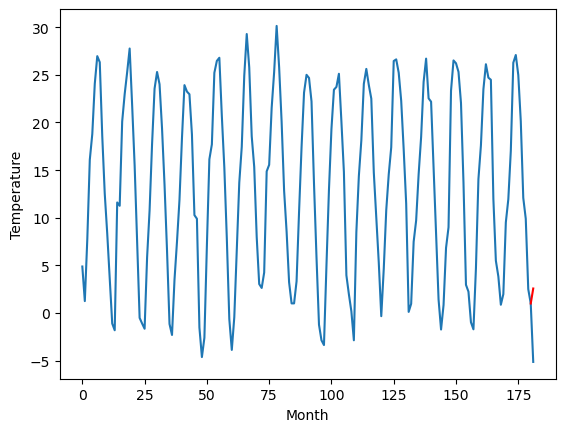

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
5.59		3.85		-1.74
[180, 181]
[14.25, 3.8528216028213498]


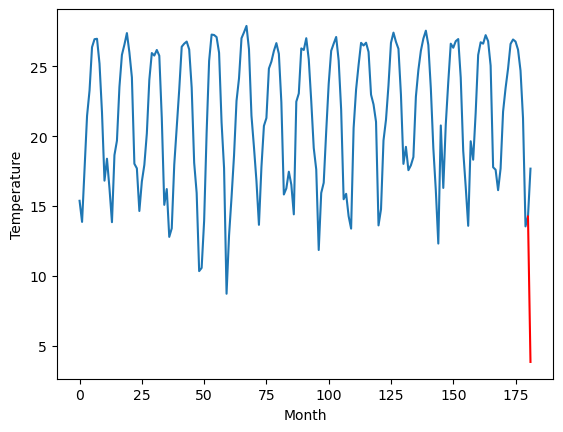

Weather Station 3:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
15.41		14.34		-1.07
[180, 181]
[9.06, 14.342810754776002]


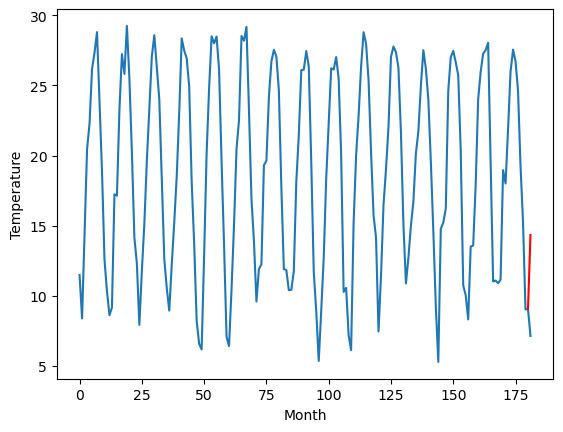

Weather Station 4:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.57		10.45		-0.12
[180, 181]
[7.48, 10.45281659603119]


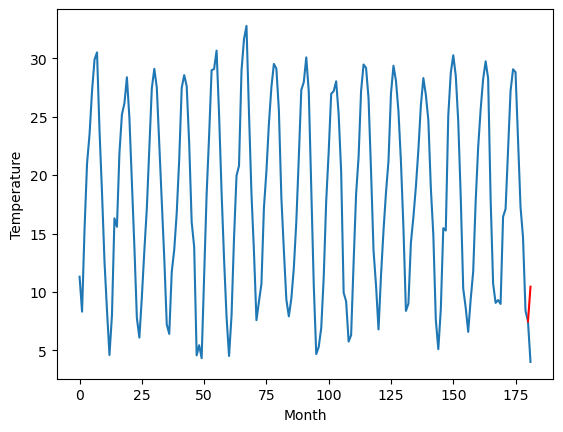

Weather Station 5:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.71		10.27		-0.44
[180, 181]
[7.33, 10.272818622589112]


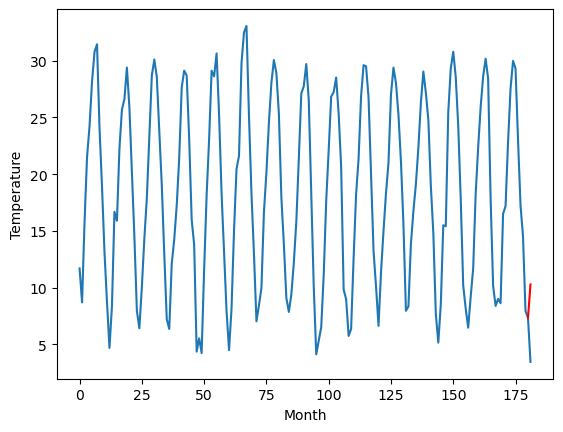

Weather Station 6:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.59		10.65		0.06
[180, 181]
[6.59, 10.652822556495666]


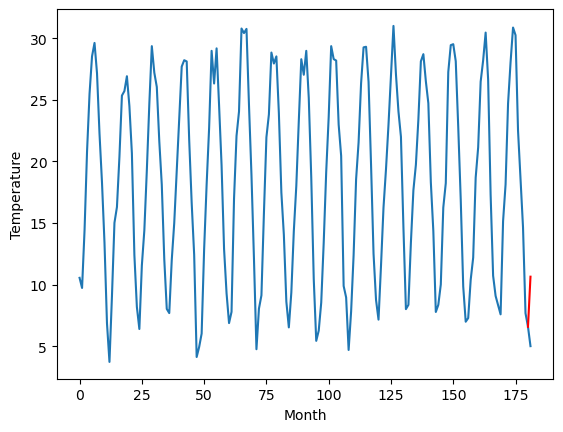

Weather Station 7:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
10.79		9.52		-1.27
[180, 181]
[6.04, 9.522808847427369]


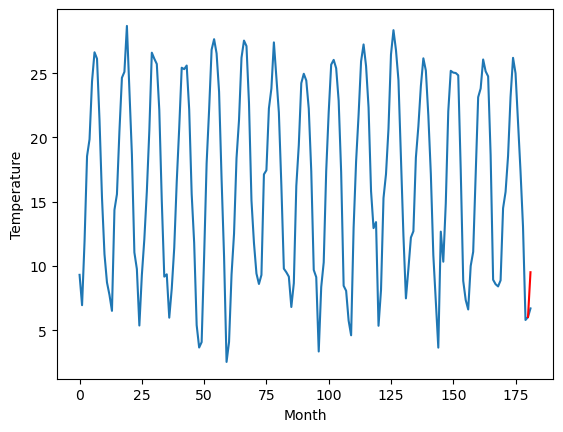

Weather Station 8:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
7.65		8.28		0.63
[180, 181]
[3.13, 8.282808847427368]


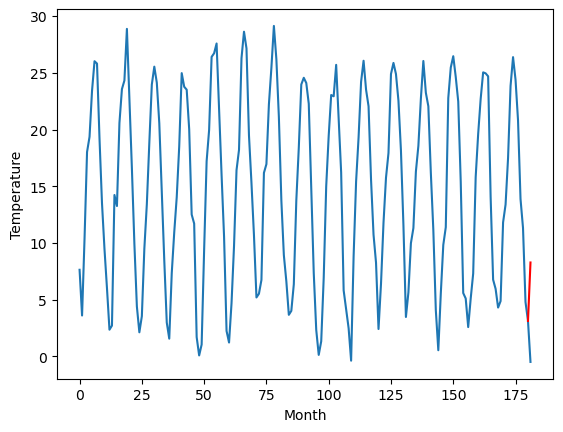

Weather Station 9:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
6.06		6.60		0.54
[180, 181]
[-0.29, 6.602803840637207]


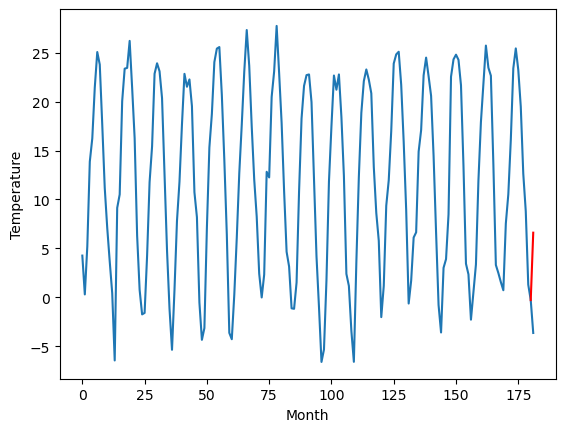

Weather Station 10:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
2.23		3.22		0.99
[180, 181]
[-1.03, 3.222803840637207]


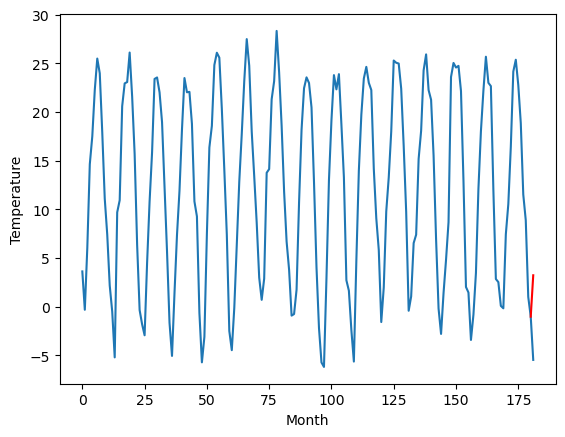

Weather Station 11:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
1.70		2.58		0.88
[180, 181]
[-2.29, 2.5828028869628907]


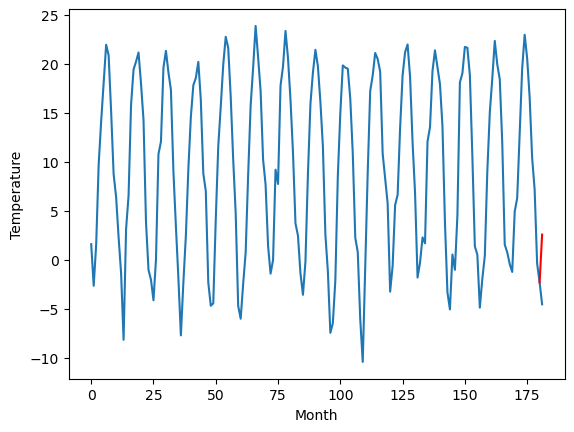

Predictions for (t+0):
    Weather_Station  Actual  Predicted
0                 0    2.11   2.582809
1                 1    5.59   3.852822
2                 2   15.41  14.342811
3                 3   10.57  10.452817
4                 4   10.71  10.272819
5                 5   10.59  10.652823
6                 6   10.79   9.522809
7                 7    7.65   8.282809
8                 8    6.06   6.602804
9                 9    2.23   3.222804
10               10    1.70   2.582803


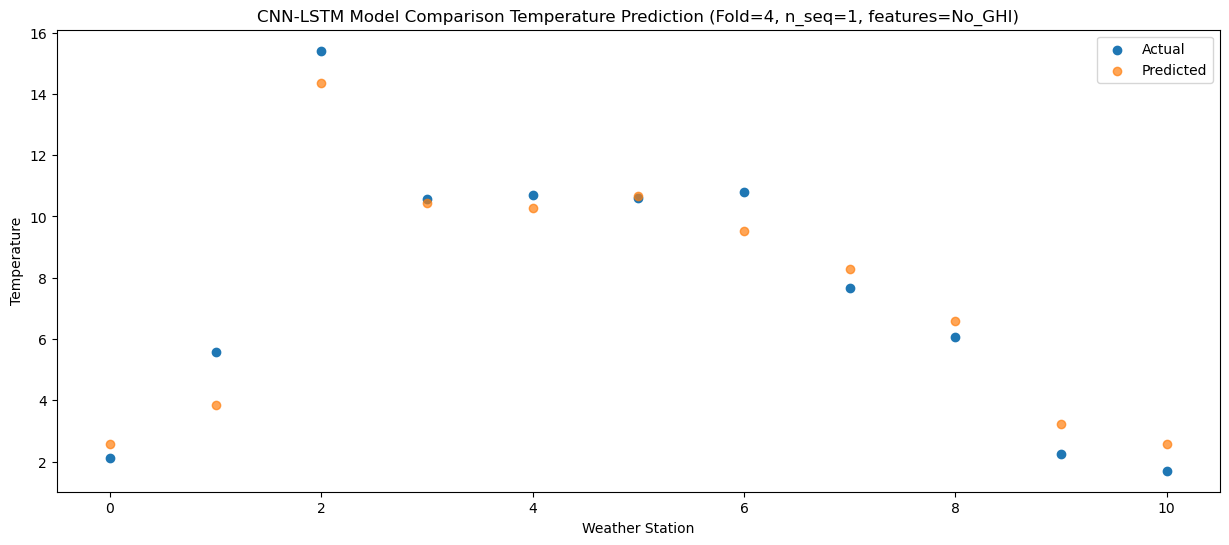

f, t:
[[ 2.11  5.59 15.41 10.57 10.71 10.59 10.79  7.65  6.06  2.23  1.7 ]]
[[ 2.58280885  3.8528216  14.34281075 10.4528166  10.27281862 10.65282256
   9.52280885  8.28280885  6.60280384  3.22280384  2.58280289]]
Year at t+1:
t+1 SKRMSE: 0.887022
t+1 KRMSE: 0.887022
t+1 MAE: 0.746616
t+1 SKMAPE: 0.174197
t+1 R2_SCORE: 0.956465
t+1 KMAPE: 0.174197
t+1 PEARSON: 0.964881
t+1 AVERAGE ACTUAL: 7.582727
Metrics for this Fold:
SKRMSE: 0.887022
KRMSE: 0.887022
MAE: 0.746616
SKMAPE: 0.174197
R2_SCORE: 0.956465
KMAPE: 0.174197
PEARSON: 0.964881
AVERAGE ACTUAL: 7.582727
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 512)            1008640   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                

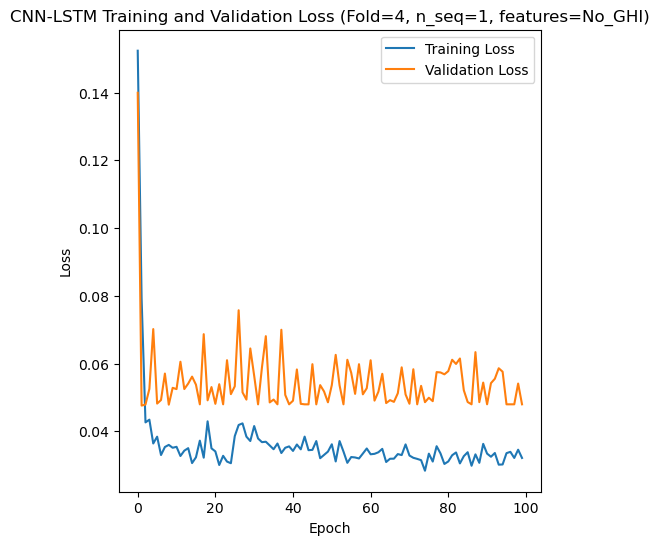

[[0.9521277065343663], [0.6872441374138099], [1.4978830554566274], [1.5109934939934189], [0.8870222361998094]]
[[array(0.95212771)], [array(0.68724414)], [array(1.49788306)], [array(1.51099349)], [array(0.88702224)]]
[[0.8617891959168701], [0.5143212572011078], [1.4331374588879677], [1.1150314877249978], [0.7466158541766081]]
[[0.12364373868710463], [0.05946371255749794], [0.18789858014567365], [0.17471638145991172], [0.1741972093029751]]
[[0.9346654152057081], [0.9217538271797129], [0.809335539765107], [0.8923585569651656], [0.9564650260604607]]
[[array(0.12364374)], [array(0.05946371)], [array(0.18789858)], [array(0.12777058)], [array(0.17419721)]]
[[array(0.95959443)], [array(0.92274577)], [array(0.96475755)], [array(0.92660454)], [array(0.96488084)]]
[ 4.43 12.87 15.34  9.   13.35 11.52 10.21  7.91  7.08  4.9   3.68  8.38
 12.    8.77 10.72 14.7  11.91 12.75  8.81  7.34  9.04  6.12  8.31  8.53
  6.94 14.74  3.03 13.35 13.35 12.68  6.71 11.63  8.9   2.92  7.75  8.28
  6.19  5.1   2.

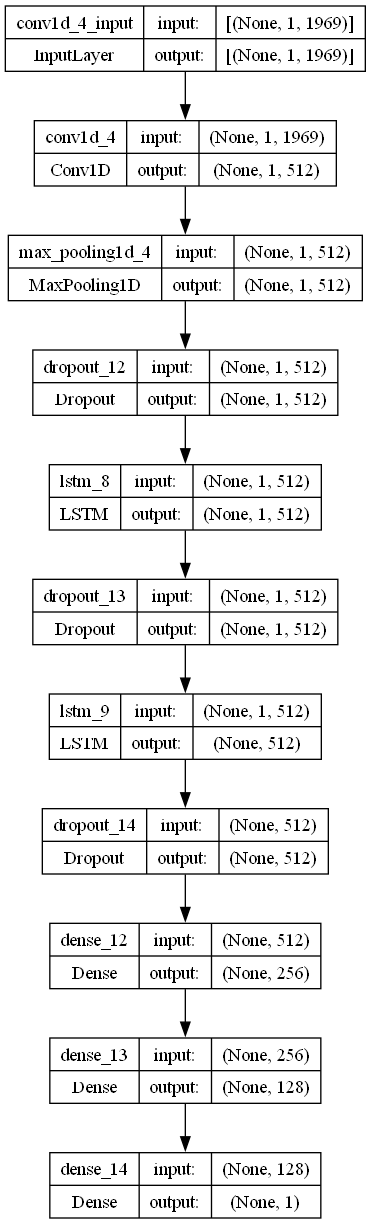

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 512
    lr = 0.0011560056879851572
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 512
    dropout_rate = 0.198600370689842

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the entire dataset in blue
    plt.plot(series[:n_lag+2+len(forecasts)].values)
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    print(xaxis)
    print(yaxis)
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Month")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 11
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:10, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))
    
    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = df.index[1:12]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(11):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")
    
        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:11, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(11):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()

    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S1_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)